In [1]:
library(devtools)
if (! 'RRphylo' %in% installed.packages()){
    install.packages('RRphylo')
}
if (! 'mvMORPH' %in% installed.packages()){
    install.packages('mvMORPH', verbose=TRUE)
}

Loading required package: usethis



In [2]:
library(phytools)
library(ape)
library(nlme)
library(tidytree)
library(RRphylo)
library(geiger)
library(piecewiseSEM)
library(dplyr)

Loading required package: ape

Loading required package: maps

If you use the ggtree package suite in published research, please
cite the appropriate paper(s):

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96

LG Wang, TTY Lam, S Xu, Z Dai, L Zhou, T Feng, P Guo, CW Dunn, BR
Jones, T Bradley, H Zhu, Y Guan, Y Jiang, G Yu. treeio: an R package
for phylogenetic tree input and output with richly annotated and
associated data. Molecular Biology and Evolution. 2020, 37(2):599-603.
doi: 10.1093/molbev/msz240 


Attaching package: ‘tidytree’


The following objects are masked from ‘package:ape’:

    drop.tip, keep.tip


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘RRphylo’ was built under R version 4.3.1”
Loading required package: emmeans


Attaching package: ‘emmeans’


The following object is masked from ‘package:devtools’:

    test



Attaching p

In [3]:
load('phylogenetic_analysis_euk.Rdata')

In [4]:
figures_dir = '../fig'

## Load and pre-process data

### Eukaryotes phylogeny

In [5]:
euk_tree = "../data/ENSEMBL_species_lists/species_clean_nospace.nwk"
euk_tree = read.tree(euk_tree)
euk_tree


Phylogenetic tree with 590 tips and 589 internal nodes.

Tip labels:
  ustilago_maydis, sporisorium_reilianum, cryptococcus_neoformans, puccinia_triticina, aspergillus_niger, aspergillus_oryzae, ...
Node labels:
  , 1, 1, 1, 1, 1, ...

Rooted; includes branch lengths.

In [6]:
# replace branches with length 0 with polytomies
euk_tree = di2multi(euk_tree, tol=1)

In [7]:
tips = euk_tree$tip.label
nodes<-sapply(tips,function(x,y) which(y==x),y=euk_tree$tip.label)
## then get the edge lengths for those nodes
edge.lengths<-setNames(euk_tree$edge.length[sapply(nodes,
    function(x,y) which(y==x),y=euk_tree$edge[,2])],names(nodes))

In [8]:
# Remove terminal branches shorter than 1M years
THRESHOLD = 1

tip.label.to.node.num = function(tree,label){
    return(which(tree$tip.label == label))
}

get_tips = function(node){
    tips = names(tip_parents[which(tip_parents == node)])
}

get.branch.len = function(tree, node){
    return(tree$edge.length[which(tree$edge[,2]==node)])
}

terminal_branch_len = c(-Inf)
while (any(terminal_branch_len < THRESHOLD)){
    # find the node numbers at the tips
    tip_node_num = sapply(euk_tree$tip.label, tip.label.to.node.num, tree=euk_tree)
    # find parent nodes of tips
    tip_parents = sapply(tip_node_num, getParent, tree=euk_tree)
    # get the children for each tip parent
    tip_parents = sapply(as.character(unique(tip_parents)), get_tips)
    # get terminal branch lengths
    #terminal_branch_len = sapply(names(tip_parents), get.branch.len, tree=euk_tree)
    terminal_branch_len = setNames(euk_tree$edge.length[sapply(tip_node_num,
    function(x,y) which(y==x),y=euk_tree$edge[,2])],names(tip_node_num))
    to_drop = c()
    for (parent in names(tip_parents)){
        #if (terminal_branch_len[[parent]] < THRESHOLD){
        if (terminal_branch_len[tip_parents[[parent]][1]] < THRESHOLD){
            to_drop = c(to_drop, tip_parents[[parent]][1])
        }
        else if (length(tip_parents[[parent]]) == 2 & terminal_branch_len[tip_parents[[parent]][2]] < THRESHOLD){
            to_drop = c(to_drop, tip_parents[[parent]][2])
        }
    }
    euk_tree = ape::drop.tip(euk_tree, to_drop)
}

In [9]:
euk_tree


Phylogenetic tree with 574 tips and 532 internal nodes.

Tip labels:
  ustilago_maydis, sporisorium_reilianum, cryptococcus_neoformans, puccinia_triticina, aspergillus_niger, aspergillus_oryzae, ...
Node labels:
  , 1, 1, 1, 1, 1, ...

Rooted; includes branch lengths.

### Intron length

In [10]:
intron_length_stats_tsv = "../output/species_level_analysis/RESULT_euk_new/all_species/intron_lengths.stats"
intron_length_stats_df = read.table(intron_length_stats_tsv, sep='\t', header = TRUE)
intron_length_stats_df = intron_length_stats_df[intron_length_stats_df$Dataset == 'all',]
rownames(intron_length_stats_df) = intron_length_stats_df[,1]
# log10 transformation of the mean intron lengths
intron_length_stats_df$log_Mean = log10(intron_length_stats_df$Mean)

In [11]:
# simplify to binomial species names (genus_species)
spec_list = strsplit(rownames(intron_length_stats_df), '_')
simplify = function(v){
    return(paste(v[1], v[2], sep='_'))
}

intron_length_stats_df$species = unlist(lapply(spec_list, simplify))

In [12]:
# Assign to kingdom
intron_length_stats_df$kingdom = intron_length_stats_df$group
intron_length_stats_df$kingdom[intron_length_stats_df$group %in% c('vertebrates', 'metazoa')] = 'animals'

In [13]:
intron_length_stats_df = intron_length_stats_df[intron_length_stats_df$species %in% euk_tree$tip.label,]

In [14]:
# make sure tree and table species all match (should return empty)
tree_species = euk_tree$tip.label
data_species = intron_length_stats_df$species
setdiff(tree_species, data_species)
setdiff(data_species, tree_species)

character(0)

character(0)

### Remove phyla with <10 species

In [15]:
# add phylum field
phylum_tsv = "../output/species_level_analysis/species_euk_phylum.tsv"
phylum_df = read.table(phylum_tsv, sep='\t', header = TRUE)
intron_length_stats_df = merge(intron_length_stats_df, phylum_df, by='species')

In [16]:
# Find which phyla have at least 10 species
species_by_phylum = as.data.frame(table(intron_length_stats_df$phylum))
species_by_phylum[species_by_phylum$Freq >= 10,]

Var1         Freq
4  Arthropoda   108 
5  Ascomycota    41 
11 Chordata     250 
13 Cnidaria      10 
20 Mollusca      11 
21 Nematoda      10 
29 Streptophyta  92

In [17]:
# list of phyla with >=10 species and corresponding list of species
phyla10 = species_by_phylum[species_by_phylum$Freq >= 10,'Var1']
phyla10_species = intron_length_stats_df[intron_length_stats_df$phylum %in% phyla10,'species']

In [18]:
# create tree containing only species from phyla with >=10 species
euk_tree_phyla10 = drop.tip(euk_tree,euk_tree$tip.label[-match(phyla10_species, euk_tree$tip.label)])

In [19]:
euk_tree_phyla10


Phylogenetic tree with 522 tips and 483 internal nodes.

Tip labels:
  aspergillus_niger, aspergillus_oryzae, aspergillus_flavus, aspergillus_terreus, aspergillus_clavatus, aspergillus_fumigatus, ...
Node labels:
  , 1, 1, 1, 1, 1, ...

Rooted; includes branch lengths.

In [20]:
write.tree(euk_tree_phyla10, 'euk_tree_phyla10.nwk')

In [21]:
# check if the remaining phyla are monophyletic
for (phyl in phyla10){
    phyl_species = intron_length_stats_df[intron_length_stats_df$phylum == phyl,]$species
    phyl_mono = is.monophyletic(euk_tree_phyla10, phyl_species)
    print(paste0(phyl, ' is monophyletic: ', phyl_mono))
}

[1] "Arthropoda is monophyletic: TRUE"
[1] "Ascomycota is monophyletic: TRUE"
[1] "Chordata is monophyletic: TRUE"
[1] "Cnidaria is monophyletic: TRUE"
[1] "Mollusca is monophyletic: TRUE"
[1] "Nematoda is monophyletic: FALSE"
[1] "Streptophyta is monophyletic: TRUE"


In [22]:
# intron length vectors for subsequent analyses
phyla10_intron_length_stats_df = intron_length_stats_df[intron_length_stats_df$species %in% phyla10_species,]
phyla10_mean_intron_length = phyla10_intron_length_stats_df$Mean
names(phyla10_mean_intron_length) = phyla10_intron_length_stats_df$species
phyla10_log_mean_intron_length = phyla10_intron_length_stats_df$log_Mean
names(phyla10_log_mean_intron_length) = phyla10_intron_length_stats_df$species

## Test for differences among phyla
Analyze several key gene structure features to determine the differences between phyla. The analysis steps are:
1. Run RRphylo to determine per-branch rates
2. Rescale the phylogeny according to inferred rates, thereby accounting for rate heterogenity and avoiding an oversimplifies BM model
3. Perform phylogenetic ANOVA test

In [22]:
species_phylum = intron_length_stats_df$phylum
names(species_phylum) = intron_length_stats_df$species
phyla10_species_phylum = phyla10_intron_length_stats_df$phylum
names(phyla10_species_phylum) = phyla10_intron_length_stats_df$species

In [23]:
analyze_feature = function(feature, transform=NULL){
    species_data = intron_length_stats_df[[feature]]
    if (! is.null(transform)){
        species_data = sapply(species_data, transform)
    }
    names(species_data) = intron_length_stats_df$species
    rrphylo = RRphylo(tree = euk_tree, y = species_data)
    rescaled_tree = rescaleRR(euk_tree, RR=rrphylo)
    # subset tree and data for phyla with >10 species
    rescaled_tree_phyla10 = drop.tip(rescaled_tree,rescaled_tree$tip.label[-match(phyla10_species, rescaled_tree$tip.label)])
    species_data_phyla10 = species_data[phyla10_species]
    # phylogenetic ANOVA
    set.seed(100)
    phyl_anova = phylANOVA(rescaled_tree_phyla10, phyla10_species_phylum, species_data_phyla10)
    # Add inferred ancestral states as node labels
    rrphylo$tree$node.label = round(rrphylo$aces[,1], digits=2)
    # prepare RRphylo plots
    rrphylo_plot = plotRR(rrphylo, species_data)
    return (list(data=species_data, rrphylo=rrphylo, phyl_ANOVA=phyl_anova, rrphylo_plot=rrphylo_plot))
}

#### Mean Intron content
Mean fraction of introns across transcripts

In [24]:
intron_content_res = analyze_feature('Mean_intron_fraction')

In [25]:
intron_content_res$phyl_ANOVA$Pf

[1] 0.01

#### Mean total exon/intron length per transcript
log10 transformed

In [26]:
tot_exon_length_res = analyze_feature('Mean_total_exon_length_per_transcript', log10)
tot_exon_length_res$phyl_ANOVA$Pf

[1] 0.545

In [27]:
tot_intron_length_res = analyze_feature('Mean_total_intron_length_per_transcript', log10)
tot_intron_length_res$phyl_ANOVA$Pf

[1] 0.02

#### Mean intron length

In [28]:
mean_intron_length_res = analyze_feature('Mean', log10)
mean_intron_length_res$phyl_ANOVA$Pf

[1] 0.062

#### Mean number of introns

In [29]:
mean_intron_count_res = analyze_feature('Mean_per_transcript')
mean_intron_count_res$phyl_ANOVA$Pf

[1] 0.007

## Ancestral states at phyla MRCAs
Find the inferred ancestral states for key gene structure features at the MRCAs of phyla.

In [30]:
# state and rate at phyla MRCAs
mrca_mean_len = c()
mrca_mean_count = c()
mrca_mean_content = c()
for (phyl in phyla10){
    phyl_species = intron_length_stats_df[intron_length_stats_df$phylum == phyl,]$species
    phyl_mrca = findMRCA(mean_intron_count_res$rrphylo$tree, phyl_species)
    mrca_count = mean_intron_count_res$rrphylo$aces[as.character(phyl_mrca),]
    mrca_mean_count = c(mrca_mean_count, mrca_count)
    phyl_mrca = findMRCA(mean_intron_length_res$rrphylo$tree, phyl_species)
    mrca_len = mean_intron_length_res$rrphylo$aces[as.character(phyl_mrca),]
    mrca_len = 10**mrca_len
    mrca_mean_len = c(mrca_mean_len, mrca_len)
    phyl_mrca = findMRCA(intron_content_res$rrphylo$tree, phyl_species)
    mrca_content = intron_content_res$rrphylo$aces[as.character(phyl_mrca),]
    mrca_mean_content = c(mrca_mean_content, mrca_content)
}

In [31]:
mrca_states = cbind(as.character(phyla10), round(mrca_mean_content, digits=2), round(mrca_mean_count, digits=2), round(mrca_mean_len, digits=2))
colnames(mrca_states) = c('Phylum', 'Mean intron content', 'Mean intron count', 'Mean intron length')
mrca_states

Phylum       Mean intron content Mean intron count Mean intron length
887  Arthropoda   0.54                5.67              1498.68           
581  Ascomycota   0.1                 1.59              118.86            
633  Chordata     0.63                6.93              1862.6            
1019 Cnidaria     0.58                6.22              1469.36           
1008 Mollusca     0.59                6.3               1490.27           
885  Nematoda     0.55                5.7               1491.88           
1034 Streptophyta 0.44                5.4               855.53

What about the eukaryotic root?

In [32]:
print(intron_content_res$rrphylo$aces[1])
print(10**mean_intron_length_res$rrphylo$aces[1])
print(mean_intron_count_res$rrphylo$aces[1])

[1] 0.599296
[1] 1870.96
[1] 7.127893


## Modeling intron content

In [6]:
rownames(intron_length_stats_df) = intron_length_stats_df$species
intron_length_stats_df$Mean_total_exon_length_per_transcript_log = log10(intron_length_stats_df$Mean_total_exon_length_per_transcript)
intron_length_stats_df$Mean_total_intron_length_per_transcript_log = log10(intron_length_stats_df$Mean_total_intron_length_per_transcript)

In [7]:
# Mean intron content ~ Mean total intron length
pgls = PGLS_fossil(modform= Mean_intron_fraction ~ Mean_total_intron_length_per_transcript_log, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
 -2056   1031 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.30047  0.01923  0.23906  0.32062  0.43047 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 1.345536e-05 

Coefficients:
                                             Estimate    StdErr t.value p.value
(Intercept)                                 0.0927166 0.0521290  1.7786 0.07584
Mean_total_intron_length_per_transcript_log 0.0686172 0.0074594  9.1988 < 2e-16
                                               
(Intercept)                                 .  
Mean_total_intron_length_per_transcript_log ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.1289	Adjusted R-squared: 0.1273 

In [8]:
# Mean intron content ~ Mean total exon length
pgls = PGLS_fossil(modform= Mean_intron_fraction ~ Mean_total_exon_length_per_transcript_log, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

    AIC  logLik 
-1976.4   991.2 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.31132  0.04853  0.30870  0.40885  0.53899 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 1.544335e-05 

Coefficients:
                                            Estimate     StdErr t.value
(Intercept)                                0.3150085  0.0512504  6.1465
Mean_total_exon_length_per_transcript_log -0.0011658  0.0038379 -0.3038
                                            p.value    
(Intercept)                               1.487e-09 ***
Mean_total_exon_length_per_transcript_log    0.7614    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.0001613	Adjusted R-squared: -0.001587 

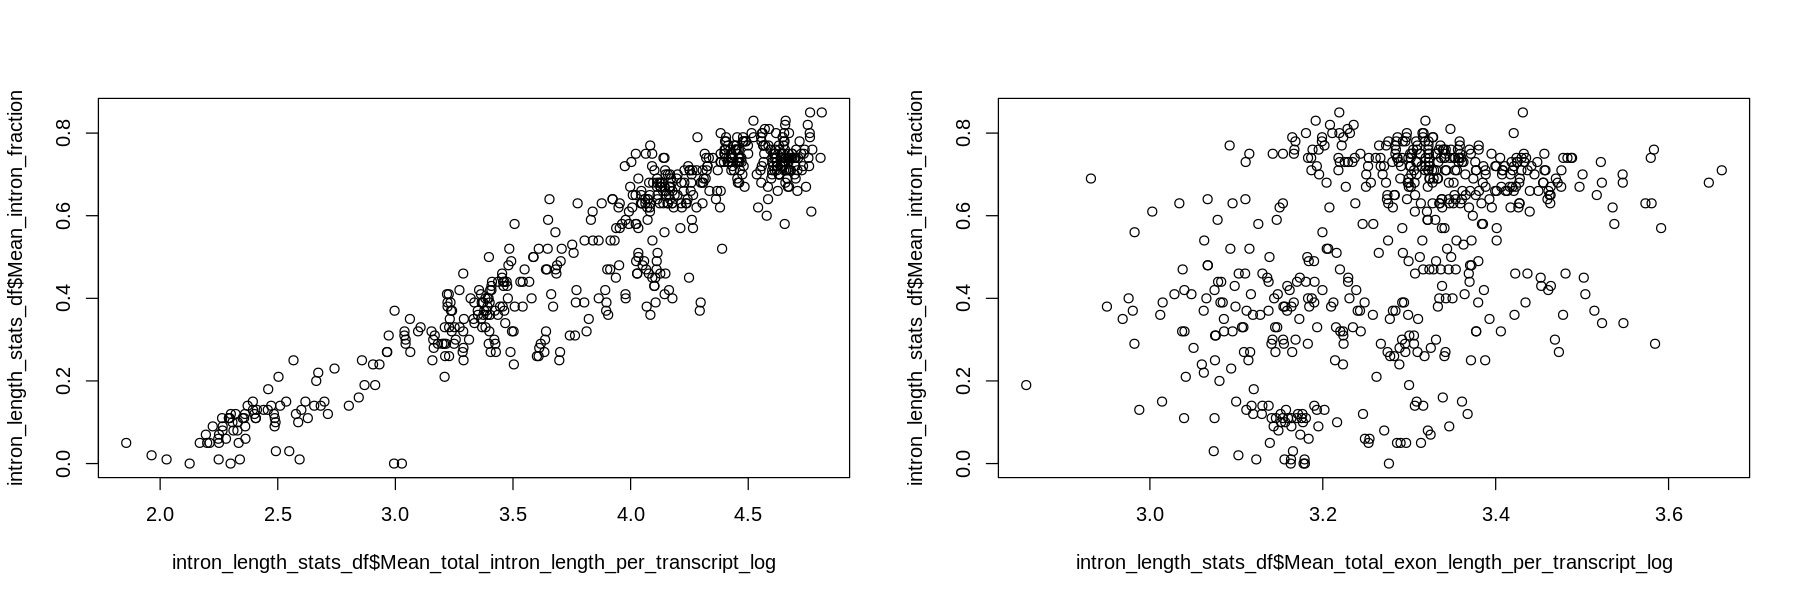

In [9]:
par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)
plot(x=intron_length_stats_df$Mean_total_intron_length_per_transcript_log, y=intron_length_stats_df$Mean_intron_fraction)
plot(x=intron_length_stats_df$Mean_total_exon_length_per_transcript_log, y=intron_length_stats_df$Mean_intron_fraction)

In [10]:
# Mean intron content ~ Mean total exon length + Mean total intron length
pgls = PGLS_fossil(modform= Mean_intron_fraction ~ Mean_total_exon_length_per_transcript_log + Mean_total_intron_length_per_transcript_log, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
 -2117   1062 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.29225  0.00981  0.19015  0.26347  0.36382 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 1.205246e-05 

Coefficients:
                                              Estimate     StdErr t.value
(Intercept)                                  0.0617214  0.0495260  1.2462
Mean_total_exon_length_per_transcript_log   -0.0353313  0.0043338 -8.1526
Mean_total_intron_length_per_transcript_log  0.1143764  0.0090240 12.6747
                                              p.value    
(Intercept)                                    0.2132    
Mean_total_exon_length_per_transcript_log   2.268e-15 ***
Mean_total_intron_length_per_transcript_log < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.2197	Adjusted R-squared: 0.217 

In [12]:
intron_content_sp_means_pgls = pgls
save(intron_content_sp_means_pgls, file='intron_content_sp_means_pgls.RData')

### intron length / intron count

In [10]:
pgls = PGLS_fossil(modform= Mean_total_intron_length_per_transcript_log ~ log_Mean * Mean_per_transcript, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

    AIC  logLik 
-1837.5   923.8 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.37585  0.02178  0.06664  0.11035  0.20711 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 1.953424e-05 

Coefficients:
                               Estimate     StdErr  t.value   p.value    
(Intercept)                  -0.5006278  0.0696131  -7.1916 2.022e-12 ***
log_Mean                      1.2713031  0.0159266  79.8227 < 2.2e-16 ***
Mean_per_transcript           0.2512532  0.0051208  49.0654 < 2.2e-16 ***
log_Mean:Mean_per_transcript -0.0572125  0.0019998 -28.6087 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.9538	Adjusted R-squared: 0.9536 

In [11]:
pgls = PGLS_fossil(modform= Mean_total_intron_length_per_transcript_log ~ log_Mean + Mean_per_transcript, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

    AIC  logLik 
-1328.5   668.3 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.37978 -0.08721 -0.00754  0.08458  0.28978 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 4.758319e-05 

Coefficients:
                     Estimate    StdErr t.value   p.value    
(Intercept)         0.2601670 0.1003193  2.5934  0.009747 ** 
log_Mean            0.9584238 0.0180542 53.0858 < 2.2e-16 ***
Mean_per_transcript 0.1096630 0.0020497 53.5024 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.8874	Adjusted R-squared: 0.8871 

In [36]:
pgls = PGLS_fossil(modform= Mean_total_intron_length_per_transcript_log ~ log_Mean, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
-300.8  153.4 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-0.7530  0.1116  0.4200  0.6123  0.8196 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 0.0002861244 

Coefficients:
            Estimate   StdErr t.value   p.value    
(Intercept) 1.371410 0.240459  5.7033 1.886e-08 ***
log_Mean    0.705559 0.042691 16.5272 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.3232	Adjusted R-squared: 0.322 

In [37]:
pgls = PGLS_fossil(modform= Mean_total_intron_length_per_transcript_log ~ Mean_per_transcript, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
-308.2  157.1 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-1.1721  0.2256  0.6464  0.9579  1.5167 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 0.0002824248 

Coefficients:
                     Estimate    StdErr t.value   p.value    
(Intercept)         2.8428154 0.2135543  13.312 < 2.2e-16 ***
Mean_per_transcript 0.0811789 0.0048152  16.859 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.3319	Adjusted R-squared: 0.3308 

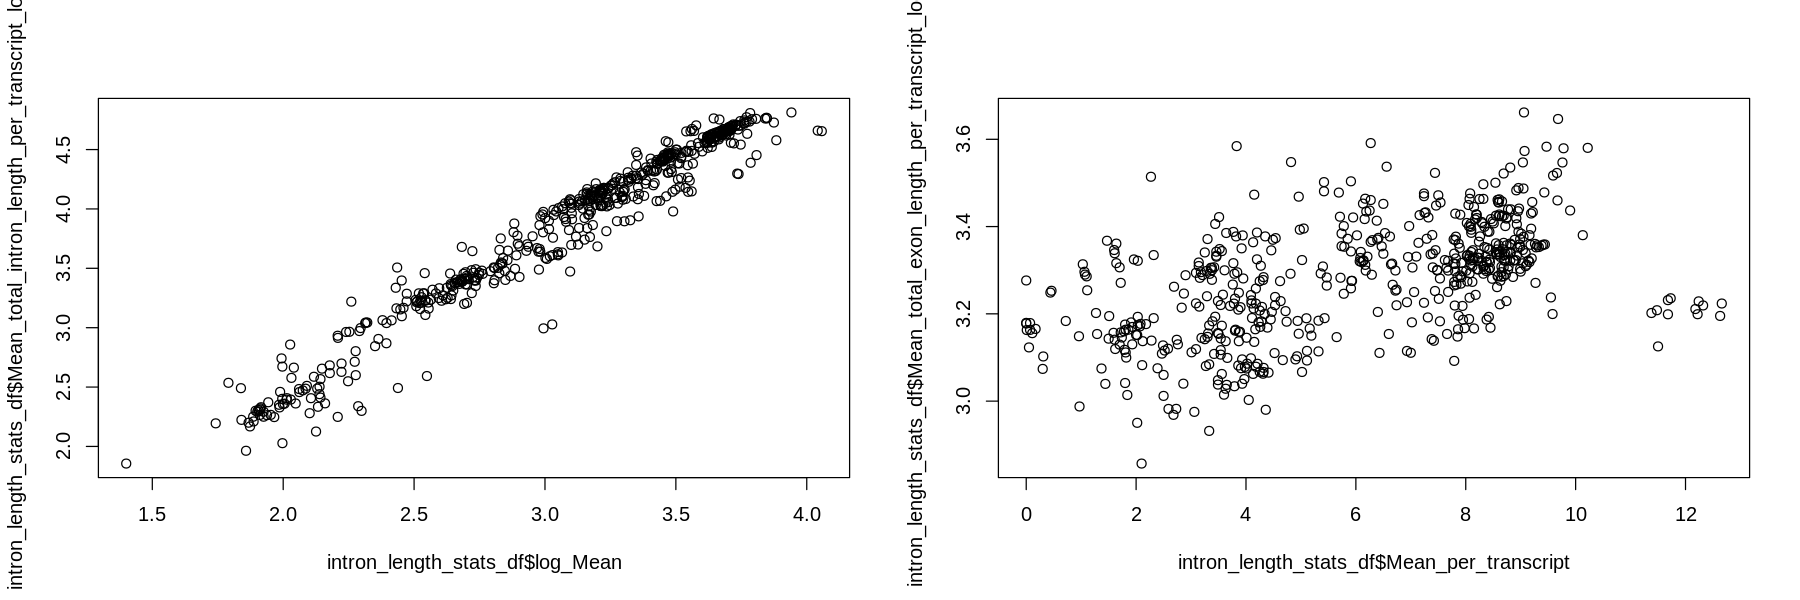

In [38]:
par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)
plot(y=intron_length_stats_df$Mean_total_intron_length_per_transcript_log, x=intron_length_stats_df$log_Mean)
plot(y=intron_length_stats_df$Mean_total_exon_length_per_transcript_log, x=intron_length_stats_df$Mean_per_transcript)

In [39]:
pgls = PGLS_fossil(modform= Mean_total_intron_length_per_transcript_log ~ log_Mean : Mean_per_transcript, data=intron_length_stats_df, RR=intron_content_res$rrphylo)
summary(pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
-396.6  201.3 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-1.0314  0.2104  0.4462  0.6546  1.3364 

Mean tip height: 1174.936
Parameter estimate(s) using ML:
sigma2: 0.0002421413 

Coefficients:
                             Estimate   StdErr t.value   p.value    
(Intercept)                  2.768220 0.197875  13.990 < 2.2e-16 ***
log_Mean:Mean_per_transcript 0.037264 0.001804  20.656 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.4272	Adjusted R-squared: 0.4262 

### Path analysis

In [5]:
rownames(intron_length_stats_df) = intron_length_stats_df$species

In [6]:
tree = rescaleRR(euk_tree, RR=intron_content_res$rrphylo)
intron_content_model = gls(Mean_intron_fraction  ~ Mean_total_exon_length_per_transcript + Mean_total_intron_length_per_transcript, data=intron_length_stats_df, correlation = corBrownian(phy=tree, form=~species), method='ML')

tree = rescaleRR(euk_tree, RR=tot_intron_length_res$rrphylo)
tot_intron_model = gls(Mean_total_intron_length_per_transcript ~ Mean_per_transcript + log_Mean, data=intron_length_stats_df, correlation = corBrownian(phy=tree, form=~species), method='ML')

In [7]:
psem = psem(intron_content_model,
            tot_intron_model,
            data = intron_length_stats_df
           )

Warning message:
“NAs detected in the dataset. Consider removing all rows with NAs to prevent fitting to different subsets of data”


In [8]:
psem_summary = summary(psem)

  |======================================================================| 100%


In [9]:
psem_summary$coefficients

Response                               
1 Mean_intron_fraction                   
2 Mean_intron_fraction                   
3 Mean_total_intron_length_per_transcript
4 Mean_total_intron_length_per_transcript
  Predictor                               Estimate Std.Error DF  Crit.Value
1 Mean_total_exon_length_per_transcript       0.00    0.0000 574 -1.5729   
2 Mean_total_intron_length_per_transcript     0.00    0.0000 574  8.2654   
3 Mean_per_transcript                      1117.38  131.8878 574  8.4722   
4 log_Mean                                22406.83 1033.7600 574 21.6751   
  P.Value Std.Estimate    
1 0.1163  -0.0048         
2 0.0000   0.2234      ***
3 0.0000   0.1829      ***
4 0.0000   0.7283      ***

In [10]:
psem_summary$dTable

Independ.Claim                                                                       
1 Mean_total_intron_length_per_transcript ~ Mean_total_exon_length_per_transcript + ...
2 Mean_intron_fraction ~ Mean_per_transcript + ...                                     
3 Mean_intron_fraction ~ log_Mean + ...                                                
  Test.Type DF  Crit.Value P.Value    
1 coef      574  2.3197    0.0207  *  
2 coef      574 18.0036    0.0000  ***
3 coef      574  6.3553    0.0000  ***

In [11]:
plot(psem)

HTML widgets cannot be represented in plain text (need html)

In [12]:
psem_summary$R2

Response                                family   link     method R.squared
1 Mean_intron_fraction                    gaussian identity none   0.06     
2 Mean_total_intron_length_per_transcript gaussian identity none   0.73

## BUSCO

### Collect data
Start by collecting data from all BUSCOs and all species into one DF

In [23]:
mean_intron_length = function(x){
    if (is.na(x)){
        return(0)
    }
    else{
        return(mean(as.numeric(strsplit(x,',')[[1]])))
    }
}

prep_busco_df = function(busco_tsv, species){
    coltypes = setNames(c('character', 'character'), c('intron_lens', 'intron_pos'))
    busco_df = read.table(busco_tsv, sep='\t', header = TRUE, row.names = 1, na.strings=c(''), colClasses = coltypes)
    busco_df = busco_df[!is.na(busco_df$canon_mRNA),]
    busco_df$log10_tot_intron_len = log10(busco_df$tot_intron_len)
    busco_df$log10_tot_intron_len = replace(busco_df$log10_tot_intron_len, is.infinite(busco_df$log10_tot_intron_len) & busco_df$log10_tot_intron_len == -Inf, 0)
    busco_df$tot_exon_len = busco_df$transcript_len - busco_df$tot_intron_len
    busco_df$log10_tot_exon_len = log10(busco_df$tot_exon_len)
    busco_df$mean_intron_len = sapply(busco_df$intron_lens, mean_intron_length)
    busco_df$species = paste(unlist(strsplit(species,'_'))[1:2], collapse='_')
    return(busco_df)
}


In [24]:
sp_list = intron_length_stats_df$X
wd = "/groups/itay_mayrose_nosnap/liorglic/Projects/intron_evolution/output/species_level_analysis/RESULT_euk_new/per_species"
all_busco_df = data.frame()
for (sp in sp_list){
    #print(sp)
    sp_busco_tsv = file.path(wd,sp,'BUSCO.stats')
    sp_busco_df = prep_busco_df(sp_busco_tsv, sp)
    all_busco_df = rbind(all_busco_df, sp_busco_df)
}

In [5]:
head(all_busco_df)

Busco_id      Sequence                  Score mRNA                     
0 1001705at2759 transcript:XM_022242839.1 294.6 transcript:XM_022242839.1
1 1003258at2759 transcript:XM_022248649.1 315.1 transcript:XM_022248649.1
2 100698at2759  transcript:XM_022253634.1 856.4 transcript:XM_022253634.1
3 1010730at2759 transcript:XM_022239785.1 437.3 transcript:XM_022239785.1
4 1014314at2759 transcript:XM_022253890.1 264.9 transcript:XM_022253890.1
5 1018517at2759 transcript:XM_022231568.1 315.0 transcript:XM_022231568.1
  canon_mRNA                transcript_len n_introns tot_intron_len intron_frac
0 transcript:XM_022242839.1 12510          13         9073          0.7252598  
1 transcript:XM_022248649.1 24660           5        22557          0.9147202  
2 transcript:XM_022253634.1 21359          18        16458          0.7705417  
3 transcript:XM_022239785.1  9947           9         7064          0.7101639  
4 transcript:XM_022253890.1 98131           5        95335          0.9715075  
5 transcript:XM_022231568.1  7241           5         4178          0.5769921  
  intron_lens                                                                  
0 1534,872,485,1767,835,589,179,261,765,663,654,166,303                        
1 18423,717,1612,1320,485                                                      
2 1780,914,1172,1396,231,1785,539,543,1002,908,800,752,850,1160,1007,2,1086,531
3 992,3093,554,318,517,606,685,104,195                                         
4 10793,21417,15229,25591,22305                                                
5 373,699,1503,434,1169                                                        
  intron_pos                                                                                       
0 131,1691,2736,3362,5217,6124,6823,7175,7609,8492,9222,9976,10266                                 
1 397,18997,20268,22139,23561                                                                      
2 104,1962,3010,4419,5890,6253,8247,8858,9508,10687,11715,12784,13673,14620,15902,16995,17053,18265
3 191,1322,4529,5138,5577,6183,6981,7759,7936                                                      
4 306,11256,32878,48269,73961                                                                      
5 243,741,1549,3213,3757                                                                           
  log10_tot_intron_len tot_exon_len log10_tot_exon_len mean_intron_len
0 3.957751             3437         3.536180             697.9231     
1 4.353281             2103         3.322839            4511.4000     
2 4.216377             4901         3.690285             914.3333     
3 3.849051             2883         3.459845             784.8889     
4 4.979252             2796         3.446537           19067.0000     
5 3.620968             3063         3.486147             835.6000     
  species           
0 acanthaster_planci
1 acanthaster_planci
2 acanthaster_planci
3 acanthaster_planci
4 acanthaster_planci
5 acanthaster_planci

In [6]:
colnames(all_busco_df)

[1] "Busco_id"             "Sequence"             "Score"               
 [4] "mRNA"                 "canon_mRNA"           "transcript_len"      
 [7] "n_introns"            "tot_intron_len"       "intron_frac"         
[10] "intron_lens"          "intron_pos"           "log10_tot_intron_len"
[13] "tot_exon_len"         "log10_tot_exon_len"   "mean_intron_len"     
[16] "species"

### Species means
As a first step, we take the means of features across all BUSCOs of each species and use them in the same way we used species means above (on all genes).

Calculate per-species means on the various features, using BUSCOs data

In [70]:
all_busco_df$mean_intron_len[is.na(all_busco_df$mean_intron_len)] = 0

In [71]:
features = c('n_introns','tot_intron_len','intron_frac','log10_tot_intron_len','tot_exon_len','log10_tot_exon_len','mean_intron_len')
all_busco_sp_means_df = all_busco_df %>% group_by(species) %>% summarise(across(all_of(features),mean), .groups = 'drop') %>% as.data.frame()

In [76]:
rownames(all_busco_sp_means_df) = all_busco_sp_means_df$species

In [77]:
head(all_busco_sp_means_df)

species                     n_introns
acanthaster_planci          acanthaster_planci          11.062745
acanthochromis_polyacanthus acanthochromis_polyacanthus 10.952000
accipiter_nisus             accipiter_nisus             10.064777
acropora_millepora          acropora_millepora          12.721116
actinia_tenebrosa           actinia_tenebrosa           12.276680
actinidia_chinensis         actinidia_chinensis          8.766798
                            tot_intron_len intron_frac log10_tot_intron_len
acanthaster_planci          11148.424      0.7163121   3.878351            
acanthochromis_polyacanthus 10434.184      0.7108405   3.828241            
accipiter_nisus             14072.202      0.7826663   3.862417            
acropora_millepora          10151.267      0.7538900   3.758259            
actinia_tenebrosa            6928.241      0.6933093   3.591632            
actinidia_chinensis          7978.893      0.6937129   3.612610            
                            tot_exon_len log10_tot_exon_len mean_intron_len
acanthaster_planci          3061.549     3.438457           1094.0152      
acanthochromis_polyacanthus 2919.144     3.373785           1149.1872      
accipiter_nisus             1967.308     3.211433           1591.7760      
acropora_millepora          2147.892     3.267848            837.0872      
actinia_tenebrosa           2142.632     3.266065            582.0400      
actinidia_chinensis         2461.549     3.315114           1036.3804

Run RRphylo on BUSCO intron content

In [10]:
busco_intron_content = all_busco_sp_means_df$intron_frac
names(busco_intron_content) = all_busco_sp_means_df$species
busco_intron_content_rrphylo = RRphylo(tree = euk_tree, y = busco_intron_content)

In [59]:
rownames(all_busco_sp_means_df) = all_busco_sp_means_df$species
busco_pgls = PGLS_fossil(modform= intron_frac ~ log10_tot_exon_len + log10_tot_intron_len, data=all_busco_sp_means_df, RR=busco_intron_content_rrphylo)
summary(busco_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
 -2580   1294 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.22163 -0.04634  0.05382  0.08715  0.13656 

Mean tip height: 1245.266
Parameter estimate(s) using ML:
sigma2: 6.297044e-06 

Coefficients:
                       Estimate     StdErr t.value   p.value    
(Intercept)           0.6280265  0.0472723  13.285 < 2.2e-16 ***
log10_tot_exon_len   -0.2433942  0.0123821 -19.657 < 2.2e-16 ***
log10_tot_intron_len  0.2216617  0.0066852  33.157 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.6706	Adjusted R-squared: 0.6695 

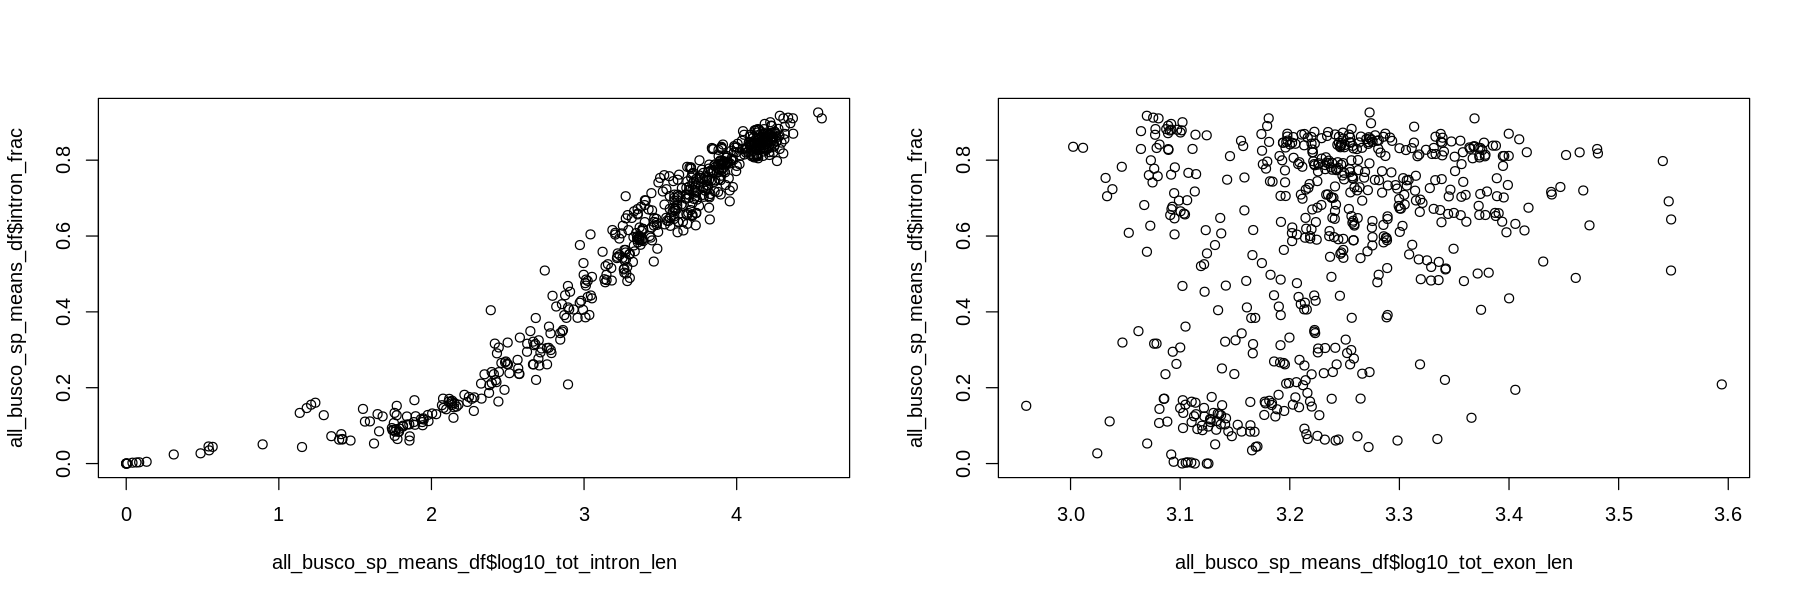

In [13]:
par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)
plot(x=all_busco_sp_means_df$log10_tot_intron_len, y=all_busco_sp_means_df$intron_frac)
plot(x=all_busco_sp_means_df$log10_tot_exon_len, y=all_busco_sp_means_df$intron_frac)

In [14]:
pgls$coefficients

(Intercept) 
                                 0.06172142 
  Mean_total_exon_length_per_transcript_log 
                                -0.03533134 
Mean_total_intron_length_per_transcript_log 
                                 0.11437641

In [15]:
busco_pgls$coefficients

(Intercept)   log10_tot_exon_len log10_tot_intron_len 
           0.6280265           -0.2433942            0.2216617

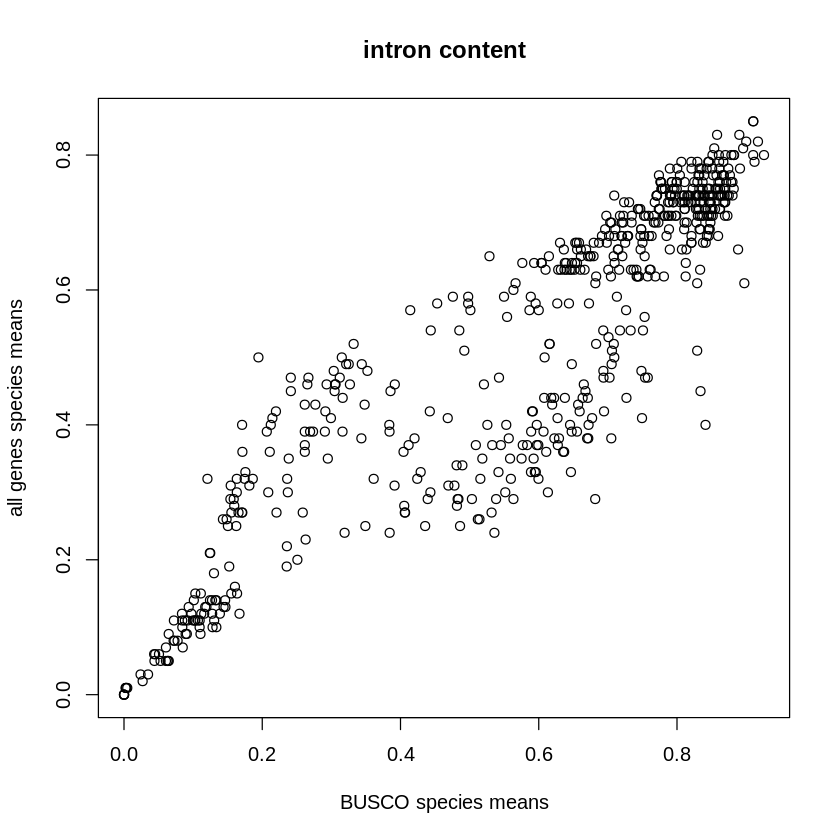

In [13]:
options(repr.plot.width=7, repr.plot.height=7)
plot(x=all_busco_sp_means_df$intron_frac, y=intron_length_stats_df$Mean_intron_fraction, main="intron content", xlab="BUSCO species means", ylab="all genes species means")

In [41]:
cor(all_busco_sp_means_df$intron_frac, intron_length_stats_df$Mean_intron_fraction)**2

[1] 0.8241884

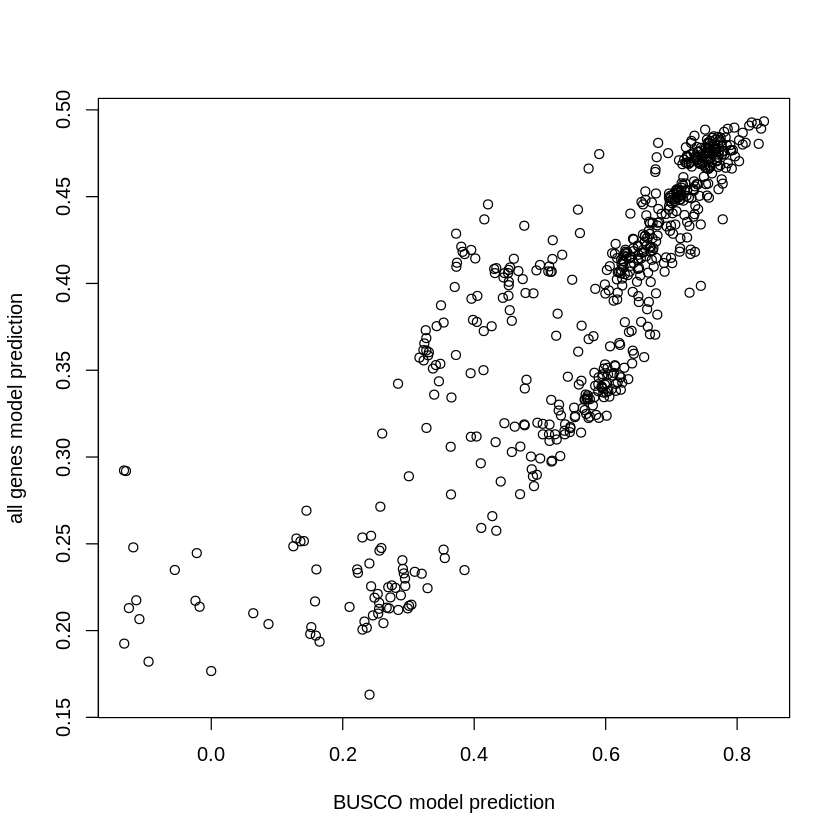

In [17]:
plot(x=predict(busco_pgls), y=predict(pgls), xlab="BUSCO model prediction", ylab="all genes model prediction")

In [45]:
cor(predict(busco_pgls), predict(pgls))**2

[1] 0.7295744

In [73]:
busco_tot_intron_length = all_busco_sp_means_df$log10_tot_intron_len
names(busco_tot_intron_length) = all_busco_sp_means_df$species
busco_tot_intron_length_rrphylo = RRphylo(tree = euk_tree, y = 

In [95]:
all_busco_sp_means_df$log10_mean_intron_len = log10(all_busco_sp_means_df$mean_intron_len)
all_busco_sp_means_df$log10_mean_intron_len[all_busco_sp_means_df$log10_mean_intron_len == -Inf] = 0

In [96]:
busco_pgls = PGLS_fossil(modform= log10_tot_intron_len ~ n_introns * log10_mean_intron_len, data=all_busco_sp_means_df, RR=busco_tot_intron_length_rrphylo)
summary(busco_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

    AIC  logLik 
-1209.8   609.9 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-1.5571  0.1666  0.3884  0.4850  0.8502 

Mean tip height: 1333.201
Parameter estimate(s) using ML:
sigma2: 7.924743e-05 

Coefficients:
                                 Estimate    StdErr t.value   p.value    
(Intercept)                     1.2755823 0.1469743  8.6789 < 2.2e-16 ***
n_introns                       0.0184868 0.0143450  1.2887     0.198    
log10_mean_intron_len           0.3939916 0.0354478 11.1147 < 2.2e-16 ***
n_introns:log10_mean_intron_len 0.0199261 0.0049237  4.0470 5.905e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.5675	Adjusted R-squared: 0.5652 

In [98]:
busco_pgls = PGLS_fossil(modform= log10_tot_intron_len ~ n_introns, data=all_busco_sp_means_df, RR=busco_tot_intron_length_rrphylo)
summary(busco_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
-866.8  436.4 

Raw residuals:
    Min      1Q  Median      3Q     Max 
-2.1506  0.1841  0.7240  1.0554  1.7107 

Mean tip height: 1333.201
Parameter estimate(s) using ML:
sigma2: 0.0001450446 

Coefficients:
             Estimate    StdErr t.value   p.value    
(Intercept) 2.1506002 0.1596558  13.470 < 2.2e-16 ***
n_introns   0.0719417 0.0058639  12.269 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.2083	Adjusted R-squared: 0.2069 

In [99]:
busco_pgls = PGLS_fossil(modform= log10_tot_intron_len ~ log10_mean_intron_len, data=all_busco_sp_means_df, RR=busco_tot_intron_length_rrphylo)
summary(busco_pgls)


Call:
phylolm::phylolm(formula = modform, data = data, phy = tree, 
    model = model, method = method)

   AIC logLik 
-967.6  486.8 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-1.95715  0.09058  0.60722  0.81884  1.14025 

Mean tip height: 1333.201
Parameter estimate(s) using ML:
sigma2: 0.000121691 

Coefficients:
                      Estimate   StdErr t.value   p.value    
(Intercept)           1.535050 0.155911  9.8457 < 2.2e-16 ***
log10_mean_intron_len 0.493470 0.029019 17.0052 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-squared: 0.3358	Adjusted R-squared: 0.3346 

### All BUSCOs
Modeling all BUSCOs from all species together

In [103]:
all_busco_df$log10_mean_intron_len = log10(all_busco_df$mean_intron_len)
all_busco_df$log10_mean_intron_len[all_busco_df$log10_mean_intron_len == -Inf] = 0

In [104]:
summary(lm(log10_tot_intron_len ~ n_introns * log10_mean_intron_len, data=all_busco_df))


Call:
lm(formula = log10_tot_intron_len ~ n_introns * log10_mean_intron_len, 
    data = all_busco_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2064 -0.0502  0.0496  0.1153  0.3028 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                     -2.435e-03  1.604e-03   -1.518    0.129    
n_introns                        6.713e-02  2.748e-04  244.321   <2e-16 ***
log10_mean_intron_len            1.169e+00  6.409e-04 1824.334   <2e-16 ***
n_introns:log10_mean_intron_len -9.965e-03  9.585e-05 -103.958   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1753 on 140120 degrees of freedom
Multiple R-squared:  0.9777,	Adjusted R-squared:  0.9777 
F-statistic: 2.044e+06 on 3 and 140120 DF,  p-value: < 2.2e-16


In [105]:
summary(lm(log10_tot_intron_len ~ n_introns, data=all_busco_df))


Call:
lm(formula = log10_tot_intron_len ~ n_introns, data = all_busco_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3674  -0.4368   0.1584   0.6147   2.7771 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.6023491  0.0037761   689.2   <2e-16 ***
n_introns   0.0844541  0.0003234   261.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9619 on 140122 degrees of freedom
Multiple R-squared:  0.3273,	Adjusted R-squared:  0.3273 
F-statistic: 6.818e+04 on 1 and 140122 DF,  p-value: < 2.2e-16


In [106]:
summary(lm(log10_tot_intron_len ~ log10_mean_intron_len, data=all_busco_df))


Call:
lm(formula = log10_tot_intron_len ~ log10_mean_intron_len, data = all_busco_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.43681 -0.21677 -0.00396  0.23675  1.52201 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.089592   0.002808   31.91   <2e-16 ***
log10_mean_intron_len 1.262347   0.001035 1219.47   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3442 on 140122 degrees of freedom
Multiple R-squared:  0.9139,	Adjusted R-squared:  0.9139 
F-statistic: 1.487e+06 on 1 and 140122 DF,  p-value: < 2.2e-16


### Per-BUSCO
Run a separate PGLS on each BUSCO

In [47]:
busco_pgls = function(busco_id){
    busco_df = all_busco_df[all_busco_df$Busco_id == busco_id,]
    rownames(busco_df) = busco_df$species
    busco_intron_content = busco_df$intron_frac
    names(busco_intron_content) = busco_df$species
    missing_species = setdiff(euk_tree$tip.label, names(busco_intron_content))
    busco_tree = drop.tip(euk_tree, missing_species)
    busco_rr = RRphylo(tree = busco_tree, y = busco_intron_content)
    busco_pgls = PGLS_fossil(modform= intron_frac ~ log10_tot_exon_len + log10_tot_intron_len, data=busco_df, RR=busco_rr)
    pgls_sum = summary(busco_pgls)
    coef_df = as.data.frame(pgls_sum$coefficients)
    coef_df$Estimate[coef_df$p.value > 10**-10] = NA
    coef = coef_df$Estimate
    names(coef) = rownames(coef_df)
    r2 = c(pgls_sum$adj.r.squared)
    names(r2) = c('R^2')
    busco_id_ = c(busco_id)
    names(busco_id_) = c('Busco_id')
    return(c(coef,r2,busco_id_))  
}

In [25]:
per_busco_pgls_df = data.frame()
for (busc in unique(all_busco_df$Busco_id)){
    print(busc)
    busc_res = busco_pgls(busc)
    per_busco_pgls_df = rbind(per_busco_pgls_df, busc_res)
    per_busco_pgls_df = setNames(per_busco_pgls_df, c('(Intercept)','log10_tot_exon_len','log10_tot_intron_len','R^2','Busco_id'))
}
save.image(file='phylogenetic_analysis_euk.Rdata')

[1] "1001705at2759"
[1] "1003258at2759"
[1] "100698at2759"
[1] "1010730at2759"
[1] "1014314at2759"
[1] "1018517at2759"
[1] "1019762at2759"
[1] "1025450at2759"
[1] "1030907at2759"
[1] "1032689at2759"
[1] "1038775at2759"
[1] "1041560at2759"
[1] "1049599at2759"
[1] "1051021at2759"
[1] "1053181at2759"
[1] "1057950at2759"
[1] "1065019at2759"
[1] "1076134at2759"
[1] "1079130at2759"
[1] "1079827at2759"
[1] "1085752at2759"
[1] "1087488at2759"
[1] "1090038at2759"
[1] "1094121at2759"
[1] "1096688at2759"
[1] "1106766at2759"
[1] "1107630at2759"
[1] "1108845at2759"
[1] "1111142at2759"
[1] "1112002at2759"
[1] "1115196at2759"
[1] "1128607at2759"
[1] "1129824at2759"
[1] "1138059at2759"
[1] "1157302at2759"
[1] "1161199at2759"
[1] "1173229at2759"
[1] "1178688at2759"
[1] "1182451at2759"
[1] "1193442at2759"
[1] "1194691at2759"
[1] "1194797at2759"
[1] "1197019at2759"
[1] "1200489at2759"
[1] "1217666at2759"
[1] "1220881at2759"
[1] "1222562at2759"
[1] "1223488at2759"
[1] "1228942at2759"
[1] "1233814at2759"
[

In [30]:
per_busco_pgls_df$log10_tot_exon_len = as.numeric(per_busco_pgls_df$log10_tot_exon_len)
per_busco_pgls_df$log10_tot_intron_len = as.numeric(per_busco_pgls_df$log10_tot_intron_len)

In [30]:
# how many BUSCOs have non-significant exon effect
sum(is.na(per_busco_pgls_df$log10_tot_exon_len))
# how many BUSCOs have non-significant intron effect
sum(is.na(per_busco_pgls_df$log10_tot_intron_len))

[1] 77

[1] 0

In [19]:
# how many BUSCOs have negative coefficient for exon length?
sum(!is.na(per_busco_pgls_df$log10_tot_exon_len) & per_busco_pgls_df$log10_tot_exon_len < 0)
# how many BUSCOs have positive coefficient for intron length?
sum(!is.na(per_busco_pgls_df$log10_tot_intron_len) & per_busco_pgls_df$log10_tot_intron_len > 0)

[1] 178

[1] 255

In [31]:
# how many BUSCOs have larger absolute values for intron length compared to exon length?
per_busco_pgls_df_sig = per_busco_pgls_df[!is.na(per_busco_pgls_df$log10_tot_exon_len),]
sum(abs(per_busco_pgls_df_sig$log10_tot_exon_len) < abs(per_busco_pgls_df_sig$log10_tot_intron_len))

[1] 78

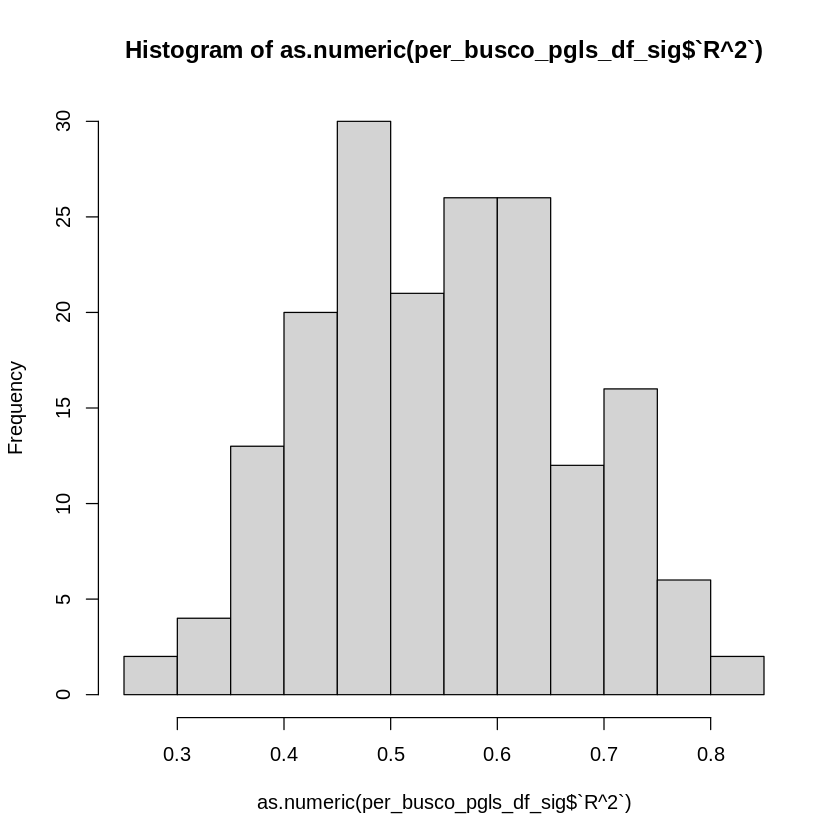

In [33]:
hist(as.numeric(per_busco_pgls_df_sig$`R^2`))

In [70]:
write.table(per_busco_pgls_df, file='per_busco_pgls.tsv', sep='\t')

In [5]:
colnames(all_busco_df)

[1] "Busco_id"             "Sequence"             "Score"               
 [4] "mRNA"                 "canon_mRNA"           "transcript_len"      
 [7] "n_introns"            "tot_intron_len"       "intron_frac"         
[10] "intron_lens"          "intron_pos"           "log10_tot_intron_len"
[13] "tot_exon_len"         "log10_tot_exon_len"   "mean_intron_len"     
[16] "species"

In [47]:
busco_pgls_intron_len = function(busco_id){
    busco_df = all_busco_df[all_busco_df$Busco_id == busco_id,c('n_introns','log10_tot_intron_len','mean_intron_len','species')]
    busco_df[is.na(busco_df)] = 0
    rownames(busco_df) = busco_df$species
    busco_df$log10_mean_intron_len = log10(busco_df$mean_intron_len)
    busco_df$log10_mean_intron_len[busco_df$log10_mean_intron_len == -Inf] = 0
    busco_tot_intron_len = busco_df$log10_tot_intron_len
    names(busco_tot_intron_len) = busco_df$species
    missing_species = setdiff(euk_tree$tip.label, names(busco_tot_intron_len))
    busco_tree = drop.tip(euk_tree, missing_species)
    busco_rr = RRphylo(tree = busco_tree, y = busco_tot_intron_len)
    full_model = PGLS_fossil(modform = log10_tot_intron_len ~ n_introns * log10_mean_intron_len, data=busco_df, RR=busco_rr)
    n_introns_model = PGLS_fossil(modform = log10_tot_intron_len ~ n_introns, data=busco_df, RR=busco_rr)
    mean_intron_len_model = PGLS_fossil(modform = log10_tot_intron_len ~ log10_mean_intron_len, data=busco_df, RR=busco_rr)
    r2 = c(busco_id)
    for (mod in list(full_model, n_introns_model, mean_intron_len_model)){
        r2 = c(r2, (summary(mod))$adj.r.squared)
    }
    names(r2) = c("Busco_id","Full_model", 'n_introns', 'mean_intron_length')
    return (r2)
}

In [48]:
per_busco_pgls_intron_len_df = data.frame()
for (busc in unique(all_busco_df$Busco_id)){
    print(busc)
    busc_res = busco_pgls_intron_len(busc)
    per_busco_pgls_intron_len_df = rbind(per_busco_pgls_intron_len_df, busc_res)
    per_busco_pgls_intron_len_df = setNames(per_busco_pgls_intron_len_df, c("Busco_id","Full_model", 'n_introns', 'mean_intron_length'))
}
save.image(file='phylogenetic_analysis_euk.Rdata')

[1] "1001705at2759"
[1] "1003258at2759"
[1] "100698at2759"
[1] "1010730at2759"
[1] "1014314at2759"
[1] "1018517at2759"
[1] "1019762at2759"
[1] "1025450at2759"
[1] "1030907at2759"
[1] "1032689at2759"
[1] "1038775at2759"
[1] "1041560at2759"
[1] "1049599at2759"
[1] "1051021at2759"
[1] "1053181at2759"
[1] "1057950at2759"
[1] "1065019at2759"
[1] "1076134at2759"
[1] "1079130at2759"
[1] "1079827at2759"
[1] "1085752at2759"
[1] "1087488at2759"
[1] "1090038at2759"
[1] "1094121at2759"
[1] "1096688at2759"
[1] "1106766at2759"
[1] "1107630at2759"
[1] "1108845at2759"
[1] "1111142at2759"
[1] "1112002at2759"
[1] "1115196at2759"
[1] "1128607at2759"
[1] "1129824at2759"
[1] "1138059at2759"
[1] "1157302at2759"
[1] "1161199at2759"
[1] "1173229at2759"
[1] "1178688at2759"
[1] "1182451at2759"
[1] "1193442at2759"
[1] "1194691at2759"
[1] "1194797at2759"
[1] "1197019at2759"
[1] "1200489at2759"
[1] "1217666at2759"
[1] "1220881at2759"
[1] "1222562at2759"
[1] "1223488at2759"
[1] "1228942at2759"
[1] "1233814at2759"
[

In [54]:
per_busco_pgls_intron_len_df$Full_model = as.numeric(per_busco_pgls_intron_len_df$Full_model)
per_busco_pgls_intron_len_df$mean_intron_length = as.numeric(per_busco_pgls_intron_len_df$mean_intron_length)
per_busco_pgls_intron_len_df$n_introns = as.numeric(per_busco_pgls_intron_len_df$n_introns)

In [56]:
# How many BUSCOs have higher partial R^2 for mean intron length?
dim(per_busco_pgls_intron_len_df[per_busco_pgls_intron_len_df$mean_intron_length > per_busco_pgls_intron_len_df$n_introns,])

[1] 255   4

In [15]:
all_busco_df[all_busco_df$Busco_id == '1001705at2759' & all_busco_df$species %in% c('mus_musculus', 'rattus_norvegicus'),]

Busco_id      Sequence                      Score
0318 1001705at2759 transcript:ENSMUST00000027700 191.6
0434 1001705at2759 transcript:ENSRNOT00000036110 294.0
     mRNA                          canon_mRNA                    transcript_len
0318 transcript:ENSMUST00000027700 transcript:ENSMUST00000027700 28225         
0434 transcript:ENSRNOT00000036110 transcript:ENSRNOT00000036110 26854         
     n_introns tot_intron_len intron_frac
0318 14        24840          0.8800709  
0434 13        23002          0.8565577  
     intron_lens                                                
0318 6524,668,646,4082,694,1967,1152,86,95,515,1231,523,901,5756
0434 6427,676,3717,676,1617,900,86,95,750,1194,538,999,5327     
     intron_pos                                                                   
0318 93,6643,7367,8071,12294,13151,15228,16500,16740,16907,17540,18841,19594,20573
0434 388,6841,7690,11548,12387,14114,15134,15374,15541,16409,17673,18441,19632    
     log10_tot_intron_len tot_exon_len log10_tot_exon_len mean_intron_len
0318 4.395152             3385         3.529559           1774.286       
0434 4.361766             3852         3.585686           1769.385       
     species          
0318 mus_musculus     
0434 rattus_norvegicus

In [104]:
tree = rescaleRR(euk_tree, RR=intron_content_res$rrphylo)

In [109]:
colnames(all_busco_df)

[1] "Busco_id"             "Sequence"             "Score"               
 [4] "mRNA"                 "canon_mRNA"           "transcript_len"      
 [7] "n_introns"            "tot_intron_len"       "intron_frac"         
[10] "intron_lens"          "intron_pos"           "log10_tot_intron_len"
[13] "tot_exon_len"         "log10_tot_exon_len"   "mean_intron_len"     
[16] "species"

In [143]:
sp_sample = sample(euk_tree$tip.label, 10)
all_busco_df_sample = all_busco_df[all_busco_df$species %in% sp_sample,]
tree_sample = drop.tip(tree,tree$tip.label[-match(sp_sample, tree$tip.label)])

In [144]:
gls = gls(intron_frac ~ log10_tot_intron_len + log10_tot_exon_len, data=all_busco_df_sample, correlation = corBrownian(phy=tree_sample, form=~species), method='ML')

In [145]:
summary(gls)

Generalized least squares fit by maximum likelihood
  Model: intron_frac ~ log10_tot_intron_len + log10_tot_exon_len 
  Data: all_busco_df_sample 
   AIC  BIC logLik
  -Inf -Inf    Inf

Correlation Structure: corBrownian
 Formula: ~species 
 Parameter estimate(s):
numeric(0)

Coefficients:
                          Value  Std.Error   t-value p-value
(Intercept)           0.7011103 0.07445573   9.41647       0
log10_tot_intron_len  0.1790973 0.00240924  74.33753       0
log10_tot_exon_len   -0.2104113 0.00838588 -25.09113       0

 Correlation: 
                     (Intr) lg10_tt_n_
log10_tot_intron_len -0.053           
log10_tot_exon_len   -0.347 -0.177    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.7319661 -0.8723914  0.3338781  0.8794696  1.2051945 

Residual standard error: 0.1261356 
Degrees of freedom: 2461 total; 2458 residual

In [36]:
mod = lm(intron_frac ~ log10_tot_intron_len + log10_tot_exon_len, data=all_busco_df)
summary(mod)
AIC(mod)


Call:
lm(formula = intron_frac ~ log10_tot_intron_len + log10_tot_exon_len, 
    data = all_busco_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29785 -0.05459  0.03146  0.06245  0.49596 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.592018   0.026900   22.01   <2e-16 ***
log10_tot_intron_len  0.276434   0.001999  138.28   <2e-16 ***
log10_tot_exon_len   -0.282505   0.008356  -33.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1092 on 2491 degrees of freedom
Multiple R-squared:  0.8858,	Adjusted R-squared:  0.8857 
F-statistic:  9663 on 2 and 2491 DF,  p-value: < 2.2e-16


[1] -3965.042

In [5]:
mod = lm(intron_frac ~ log10_tot_intron_len + log10_tot_exon_len, data=busco_df)
summary(mod)
AIC(mod)


Call:
lm(formula = intron_frac ~ log10_tot_intron_len + log10_tot_exon_len, 
    data = busco_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31451 -0.01379  0.02107  0.03392  0.29142 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.689427   0.053880   12.80   <2e-16 ***
log10_tot_intron_len  0.237510   0.005704   41.64   <2e-16 ***
log10_tot_exon_len   -0.252914   0.016379  -15.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06185 on 248 degrees of freedom
Multiple R-squared:  0.8756,	Adjusted R-squared:  0.8746 
F-statistic: 872.7 on 2 and 248 DF,  p-value: < 2.2e-16


[1] -679.7752

In [6]:
mod = lm(intron_frac ~ log10_tot_intron_len, data=busco_df)
summary(mod)
AIC(mod)


Call:
lm(formula = intron_frac ~ log10_tot_intron_len, data = busco_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.34365 -0.03783  0.00803  0.05837  0.18747 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -0.063817   0.031978  -1.996   0.0471 *  
log10_tot_intron_len  0.211721   0.007623  27.774   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08645 on 249 degrees of freedom
Multiple R-squared:  0.756,	Adjusted R-squared:  0.755 
F-statistic: 771.4 on 1 and 249 DF,  p-value: < 2.2e-16


[1] -512.6836

In [7]:
mod = lm(intron_frac ~ log10_tot_exon_len, data=busco_df)
summary(mod)
AIC(mod)


Call:
lm(formula = intron_frac ~ log10_tot_exon_len, data = busco_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83472 -0.04664  0.05218  0.10738  0.18992 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.99226    0.15061   6.588 2.63e-10 ***
log10_tot_exon_len -0.05322    0.04418  -1.205    0.229    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1745 on 249 degrees of freedom
Multiple R-squared:  0.005794,	Adjusted R-squared:  0.001801 
F-statistic: 1.451 on 1 and 249 DF,  p-value: 0.2295


[1] -160.1109

In [8]:
mod_full = lm(intron_frac ~ log10_tot_intron_len + log10_tot_exon_len, data=busco_df)
mod_part1 = lm(intron_frac ~ log10_tot_exon_len, data=busco_df)
mod_part2 = lm(intron_frac ~ log10_tot_intron_len, data=busco_df)

In [9]:
library(asbio)
partial.R2(mod_part1, mod_full)
partial.R2(mod_part2, mod_full)

Loading required package: tcltk



[1] 0.8748627

[1] 0.4901669

---

In [70]:
mod = lm(log10_tot_intron_len ~ n_introns + log10(mean_intron_len), data=busco_df[busco_df$tot_intron_len > 0,])
summary(mod)
AIC(mod)


Call:
lm(formula = log10_tot_intron_len ~ n_introns + log10(mean_intron_len), 
    data = busco_df[busco_df$tot_intron_len > 0, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72125 -0.05976  0.05022  0.09417  0.11174 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.57883    0.07110   8.141 2.02e-14 ***
n_introns               0.03119    0.00101  30.883  < 2e-16 ***
log10(mean_intron_len)  1.00812    0.02134  47.234  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1342 on 244 degrees of freedom
Multiple R-squared:  0.9257,	Adjusted R-squared:  0.9251 
F-statistic:  1521 on 2 and 244 DF,  p-value: < 2.2e-16


[1] -286.2668

In [74]:
mod = lm(log10_tot_intron_len ~ n_introns + log10(mean_intron_len) +  log10(mean_intron_len)*n_introns, data=busco_df[busco_df$tot_intron_len > 0,])
summary(mod)
AIC(mod)


Call:
lm(formula = log10_tot_intron_len ~ n_introns + log10(mean_intron_len) + 
    log10(mean_intron_len) * n_introns, data = busco_df[busco_df$tot_intron_len > 
    0, ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68510 -0.05737  0.04608  0.08668  0.15179 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.8950363  0.1121902   7.978 5.87e-14 ***
n_introns                        0.0008955  0.0085012   0.105 0.916197    
log10(mean_intron_len)           0.9077458  0.0348833  26.022  < 2e-16 ***
n_introns:log10(mean_intron_len) 0.0096378  0.0026859   3.588 0.000403 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.131 on 243 degrees of freedom
Multiple R-squared:  0.9295,	Adjusted R-squared:  0.9286 
F-statistic:  1068 on 3 and 243 DF,  p-value: < 2.2e-16


[1] -297.0194

In [76]:
mod = lm(log10_tot_intron_len ~ n_introns, data=busco_df[busco_df$tot_intron_len > 0,])
summary(mod)
AIC(mod)


Call:
lm(formula = log10_tot_intron_len ~ n_introns, data = busco_df[busco_df$tot_intron_len > 
    0, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5898 -0.2480 -0.0078  0.2284  1.7125 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.866829   0.046068  83.937   <2e-16 ***
n_introns   0.028723   0.003206   8.959   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4265 on 245 degrees of freedom
Multiple R-squared:  0.2468,	Adjusted R-squared:  0.2437 
F-statistic: 80.26 on 1 and 245 DF,  p-value: < 2.2e-16


[1] 283.9908

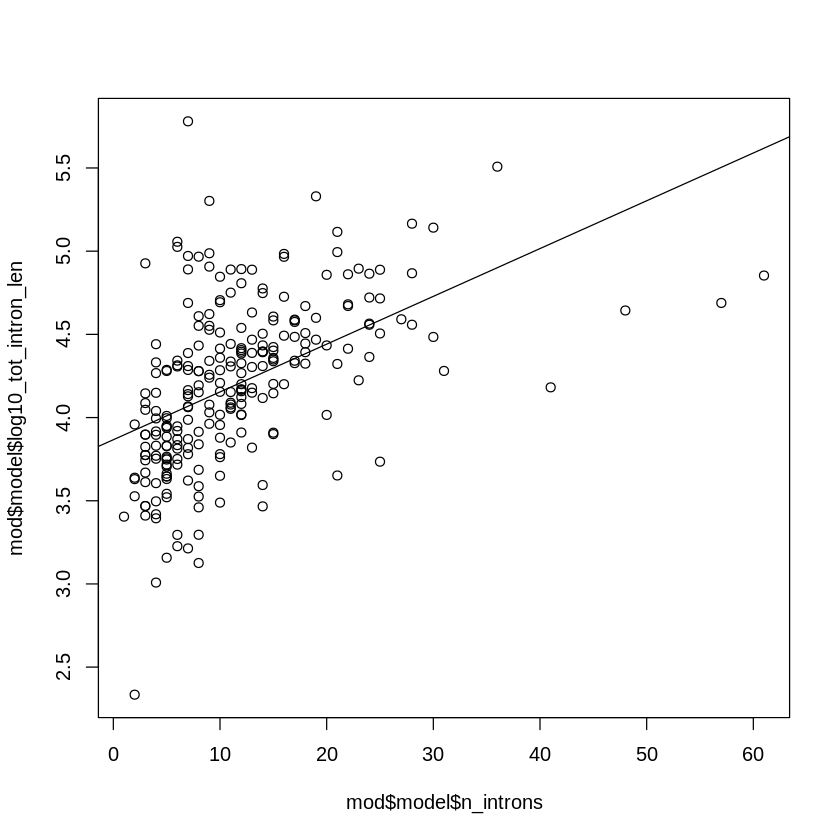

In [81]:
plot(x=mod$model$n_introns, y=mod$model$log10_tot_intron_len)
abline(mod)

In [72]:
mod = lm(log10_tot_intron_len ~ log10(mean_intron_len), data=busco_df[busco_df$tot_intron_len > 0,])
summary(mod)
AIC(mod)


Call:
lm(formula = log10_tot_intron_len ~ log10(mean_intron_len), data = busco_df[busco_df$tot_intron_len > 
    0, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9628 -0.1963  0.0235  0.1989  0.8138 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             1.05139    0.15353   6.848 5.99e-11 ***
log10(mean_intron_len)  0.97398    0.04713  20.667  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2967 on 245 degrees of freedom
Multiple R-squared:  0.6355,	Adjusted R-squared:  0.634 
F-statistic: 427.1 on 1 and 245 DF,  p-value: < 2.2e-16


[1] 104.7212

## RRphylo multiple regression
Since we found that intron length and count are strongly correlated to intron content, we include them in the RRphylo model. (not sure if this is actually needed...)

In [35]:
intron_count_pred = c(mean_intron_count_res$rrphylo$aces[,1], mean_intron_count_res$data)
intron_length_pred = c(mean_intron_length_res$rrphylo$aces[,1], mean_intron_length_res$data)
x1_pred = cbind(intron_count_pred, intron_length_pred)

In [36]:
rrphylo_multi = RRphylo(tree = euk_tree, y = intron_content_res$data, x1 = x1_pred)

In [37]:
rescaled_tree = rescaleRR(euk_tree, RR=rrphylo_multi)
rescaled_tree_phyla10 = drop.tip(rescaled_tree,rescaled_tree$tip.label[-match(phyla10_species, rescaled_tree$tip.label)])
species_data_phyla10 = intron_content_res$data[phyla10_species]
set.seed(100)
phyl_anova = phylANOVA(rescaled_tree_phyla10, phyla10_species_phylum, species_data_phyla10)

In [38]:
phyl_anova$Pf

[1] 0.008

Quite similar to the p=0.1 obtained without the additional covariates...

In [52]:
save.image(file='phylogenetic_analysis_euk.Rdata')

In [77]:
rrphylo_multi_plot = plotRR(rrphylo_multi, intron_content_res$data)

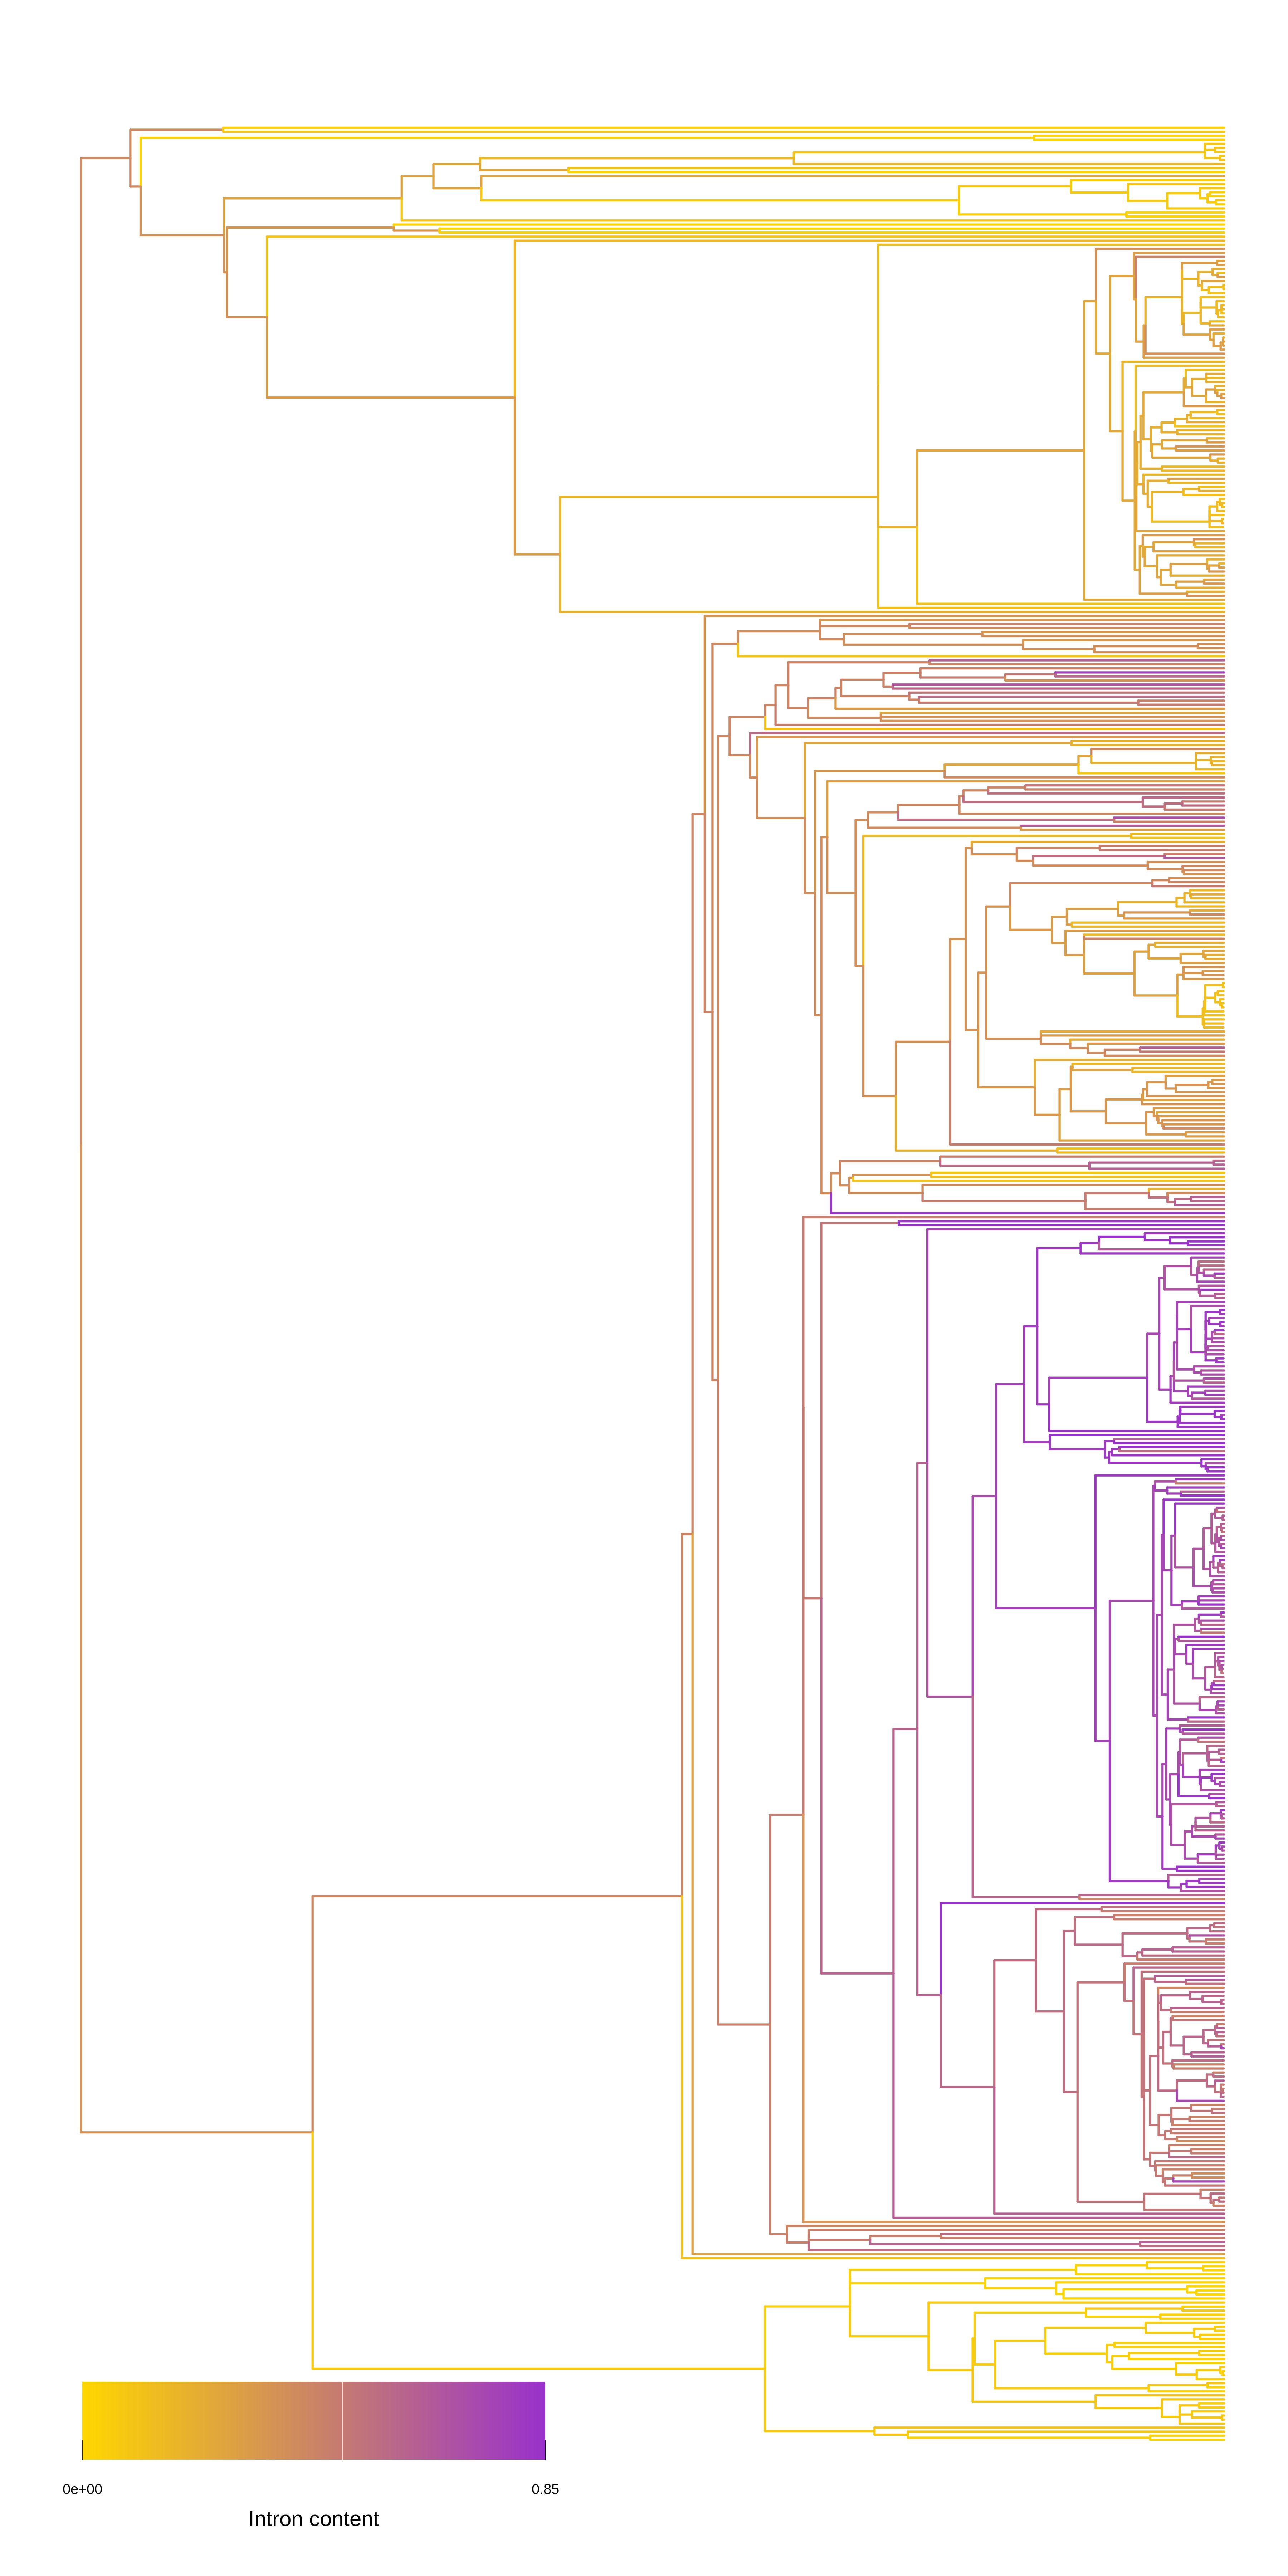

In [64]:
options(repr.plot.width=30, repr.plot.height=60)
color_pal = colorRampPalette(c("gold", "darkorchid"))
tree_args = list(edge.width=5)
colorbar_args = list(direction='horizontal',x=2,y=-4, height=0.5,width=1.5,border=NA,title.pos='bottom',labs.cex=2,title='Intron content',title.cex=3,title.adj=c(0.5,-4))
rrphylo_multi_plot$plotRRphen(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)

In [65]:
fig_name = 'fig_2a'
fig_path = file.path(figures_dir, paste0(fig_name,'.pdf'))
pdf(fig_path, width=30, height=60)
rrphylo_multi_plot$plotRRphen(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)
dev.off()

png 
  2

In [78]:
options(repr.plot.width=8, repr.plot.height=8)

In [16]:
rrphylo_multi$tree$node.label = rrphylo_multi$aces

In [17]:
euk_tree_phyla10_anc_frac = drop.tip(rrphylo_multi$tree,rrphylo_multi$tree$tip.label[-match(phyla10_species, rrphylo_multi$tree$tip.label)])

In [16]:
write.tree(euk_tree_phyla10_anc_frac, file='euk_tree_phyla10_anc_frac.nwk')

In [6]:
mean_intron_length_res$rrphylo$tree$node.label = mean_intron_length_res$rrphylo$aces
euk_tree_phyla10_anc_length = drop.tip(mean_intron_length_res$rrphylo$tree,mean_intron_length_res$rrphylo$tree$tip.label[-match(phyla10_species, mean_intron_length_res$rrphylo$tree$tip.label)])
write.tree(euk_tree_phyla10_anc_length, file='euk_tree_phyla10_anc_length.nwk')

In [7]:
mean_intron_count_res$rrphylo$tree$node.label = mean_intron_count_res$rrphylo$aces
euk_tree_phyla10_anc_count = drop.tip(mean_intron_count_res$rrphylo$tree,mean_intron_count_res$rrphylo$tree$tip.label[-match(phyla10_species, mean_intron_count_res$rrphylo$tree$tip.label)])
write.tree(euk_tree_phyla10_anc_count, file='euk_tree_phyla10_anc_count.nwk')

## Vertebrates
Fish vs. other vertebrates

In [81]:
vert_list = intron_length_stats_df[intron_length_stats_df$group == 'vertebrates','species']

In [83]:
vert_tree = keep.tip(rescaled_tree, vert_list)

In [62]:
vert_stats_df = intron_length_stats_df[intron_length_stats_df$specie %in% vert_list,]

In [84]:
teleosts_list = '/groups/itay_mayrose_nosnap/liorglic/Projects/intron_evolution/output/species_level_analysis/teleost.list'
teleosts_list = read.table(teleosts_list)$V1

In [105]:
vert_stats_df$is_teleost = vert_stats_df$species %in% teleosts_list
vert_group = vert_stats_df$is_teleost
names(vert_group) = vert_stats_df$species

In [106]:
vert_data = vert_stats_df$Mean_intron_fraction
names(vert_data) = vert_stats_df$species
phylANOVA(vert_tree, vert_group, vert_data)$Pf

[1] 0.126

In [107]:
vert_data = vert_stats_df$log_Mean
names(vert_data) = vert_stats_df$species
phylANOVA(vert_tree, vert_group, vert_data)$Pf

[1] 0.034

In [108]:
vert_data = vert_stats_df$Mean_per_transcript
names(vert_data) = vert_stats_df$species
phylANOVA(vert_tree, vert_group, vert_data)$Pf

[1] 0.814

## Evolutionary change

In [45]:
euk_tree_tip_numbers = seq(1:length(euk_tree$tip.label))
names(euk_tree_tip_numbers) = euk_tree$tip.label

In [46]:
convert = function(x){
    if (x %in% names(euk_tree_tip_numbers)){
        return(euk_tree_tip_numbers[x])
    }
    else{
        return(x)
    }
}

In [43]:
rrphylo_rates = as.data.frame(rrphylo_multi$rates)
colnames(rrphylo_rates) = c('Rate')
rownames(rrphylo_rates) = sapply(rownames(rrphylo_rates), convert)

In [45]:
# rates on branches within each phylum
rates_df = data.frame()
mrca = c()
for (phyl in phyla10){
    phyl_species = intron_length_stats_df[intron_length_stats_df$phylum == phyl,]$species
    phyl_mrca = findMRCA(euk_tree, phyl_species)
    mrca = c(mrca, as.character(phyl_mrca))
    # nodes under MRCA
    phyl_nodes = as.character(getDescendants(euk_tree, phyl_mrca))  
    phyl_rates = rrphylo_rates[phyl_nodes,1,drop=FALSE]
    phyl_rates$type = 'under'
    # nodes above MRCA
    path_to_root = getMommy(euk_tree, phyl_mrca)
    path_to_root = as.character(c(head(path_to_root, -1), phyl_mrca))
    path_to_root_rates = rrphylo_rates[path_to_root,1,drop=FALSE]
    path_to_root_rates$type = 'above'
    # combine
    phyl_rates = rbind(phyl_rates, path_to_root_rates)
    phyl_rates$node = rownames(phyl_rates)
    colnames(phyl_rates) = c('Rate', 'type', 'node')
    phyl_rates$phylum = phyl
    rates_df = rbind(rates_df, phyl_rates)
}

In [51]:
# DF of branch lengths
br_df = as.data.frame(cbind(euk_tree_phyla10$edge[,2], euk_tree_phyla10$edge.length))
colnames(br_df) = c('node','branch_length')

In [52]:
# merge branch length and rates data
rates_br_df = merge(br_df, rates_df, by = 'node', all = TRUE)

In [54]:
# write to file (analyze and plot with python)
write.table(rates_br_df, file='br_len_rates.tsv', sep = '\t', row.names = FALSE)

## Rate shifts

In [79]:
intron_content_res$rate_shifts = search.shift(intron_content_res$rrphylo, status.type="clade", f=10)

In [81]:
intron_content_res$rate_shifts_plot = plotShift(RR=intron_content_res$rrphylo,SS=intron_content_res$rate_shifts)

In [80]:
intron_content_res$rate_shifts$single.clades

rate.difference p.value
577  -0.0004655938   0.001  
1003 -0.0006396813   0.001  
822  -0.0003245614   0.003  
703  -0.0004961826   0.018  
775   0.0020991319   1.000  
1104  0.0028032129   1.000

In [55]:
intron_content_multi_rate_shifts = search.shift(rrphylo_multi, status.type="clade", f=10)
intron_content_multi_rate_shifts$single.clades

rate.difference p.value
577  -0.0004377736   0.001  
1003 -0.0006216544   0.001  
822  -0.0003313248   0.005  
775   0.0017476544   0.998  
1104  0.0028056501   1.000

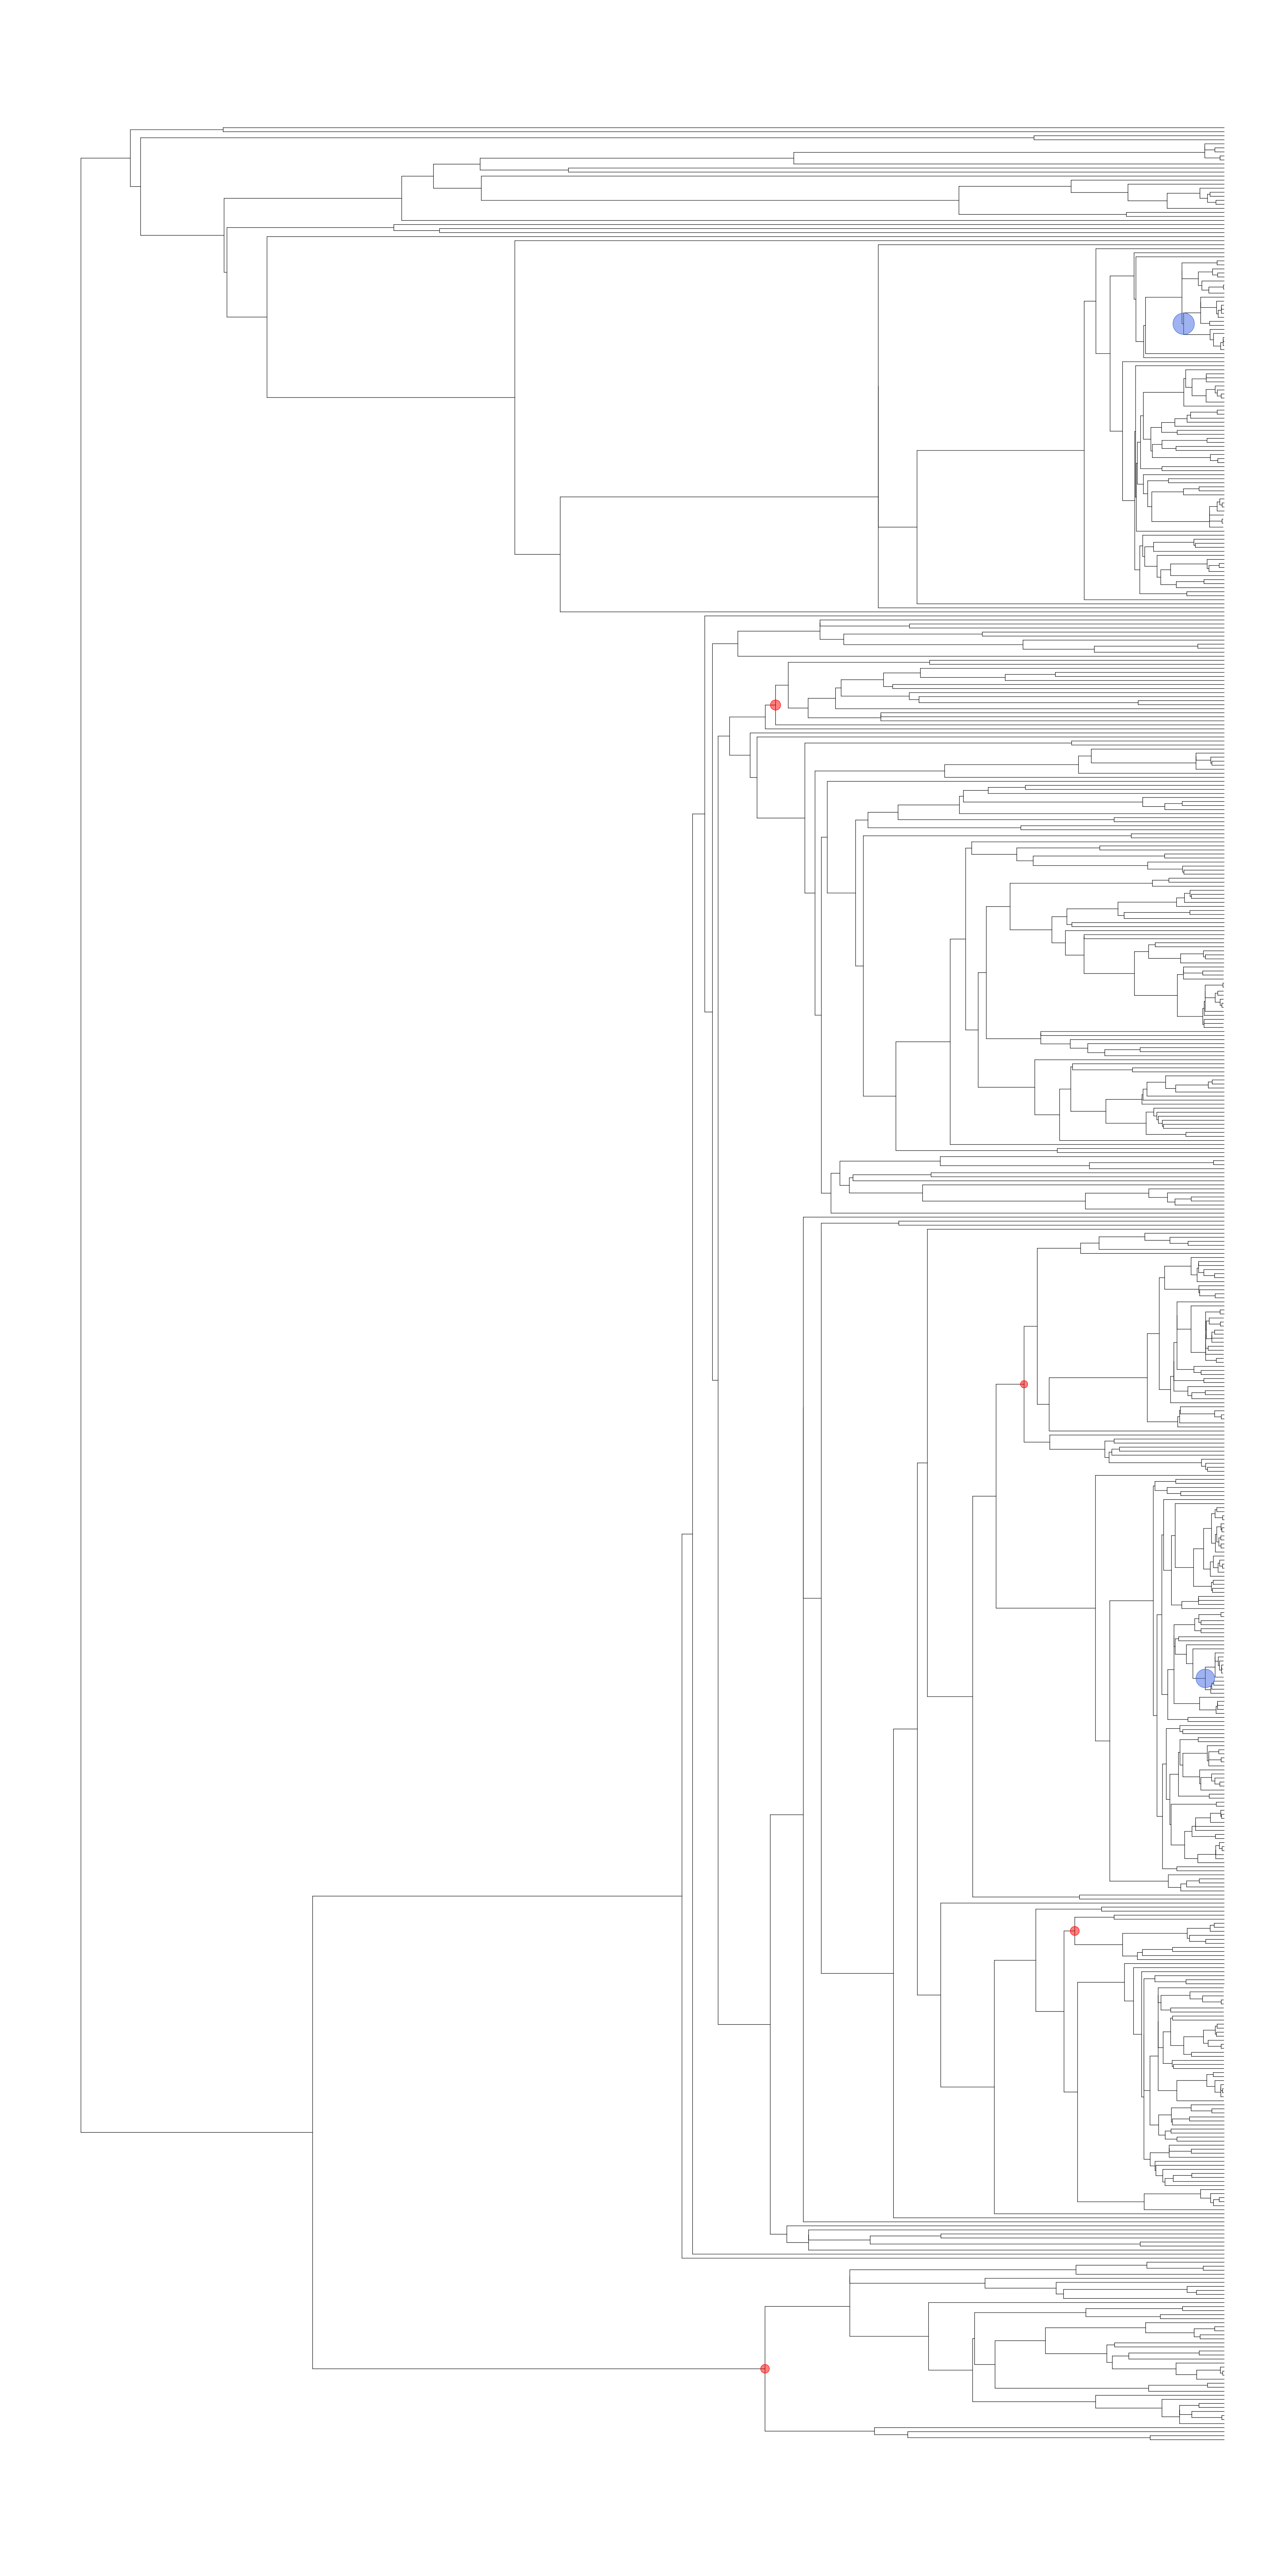

In [82]:
intron_content_res$rate_shifts_plot$plotClades()

In [93]:
for (phyl in phyla10){
    phyl_species = intron_length_stats_df[intron_length_stats_df$phylum == phyl,]$species
    phyl_mrca = findMRCA(intron_content_res$rrphylo$tree, phyl_species)
    print(paste(phyl,phyl_mrca))
}

[1] "Arthropoda 887"
[1] "Ascomycota 581"
[1] "Chordata 633"
[1] "Cnidaria 1019"
[1] "Mollusca 1008"
[1] "Nematoda 885"
[1] "Streptophyta 1034"


In [96]:
tmp_shifts = search.shift(intron_content_res$rrphylo, status.type="clade", node=c(581, 887,633, 1019,1008,885,1034))
tmp_shifts$single.clades

rate.difference p.value
581   1.131553e-04   0.941  
887   1.778878e-04   1.000  
633   6.261650e-04   1.000  
1019 -1.379339e-04   0.044  
1008 -8.806225e-05   0.253  
885   1.811122e-04   1.000  
1034  1.289518e-03   1.000

In [86]:
mean_intron_count_res$rate_shifts = search.shift(mean_intron_count_res$rrphylo, status.type="clade", f=10)
mean_intron_count_res$rate_shifts_plot = plotShift(RR=mean_intron_count_res$rrphylo,SS=mean_intron_count_res$rate_shifts)
mean_intron_count_res$rate_shifts$single.clades

rate.difference p.value
577  -0.009479984    0.001  
1002 -0.009952594    0.001  
1061 -0.007227961    0.014  
1127 -0.006590712    0.019  
1104  0.015102633    0.987  
775   0.045131650    1.000  
943   0.023956176    1.000

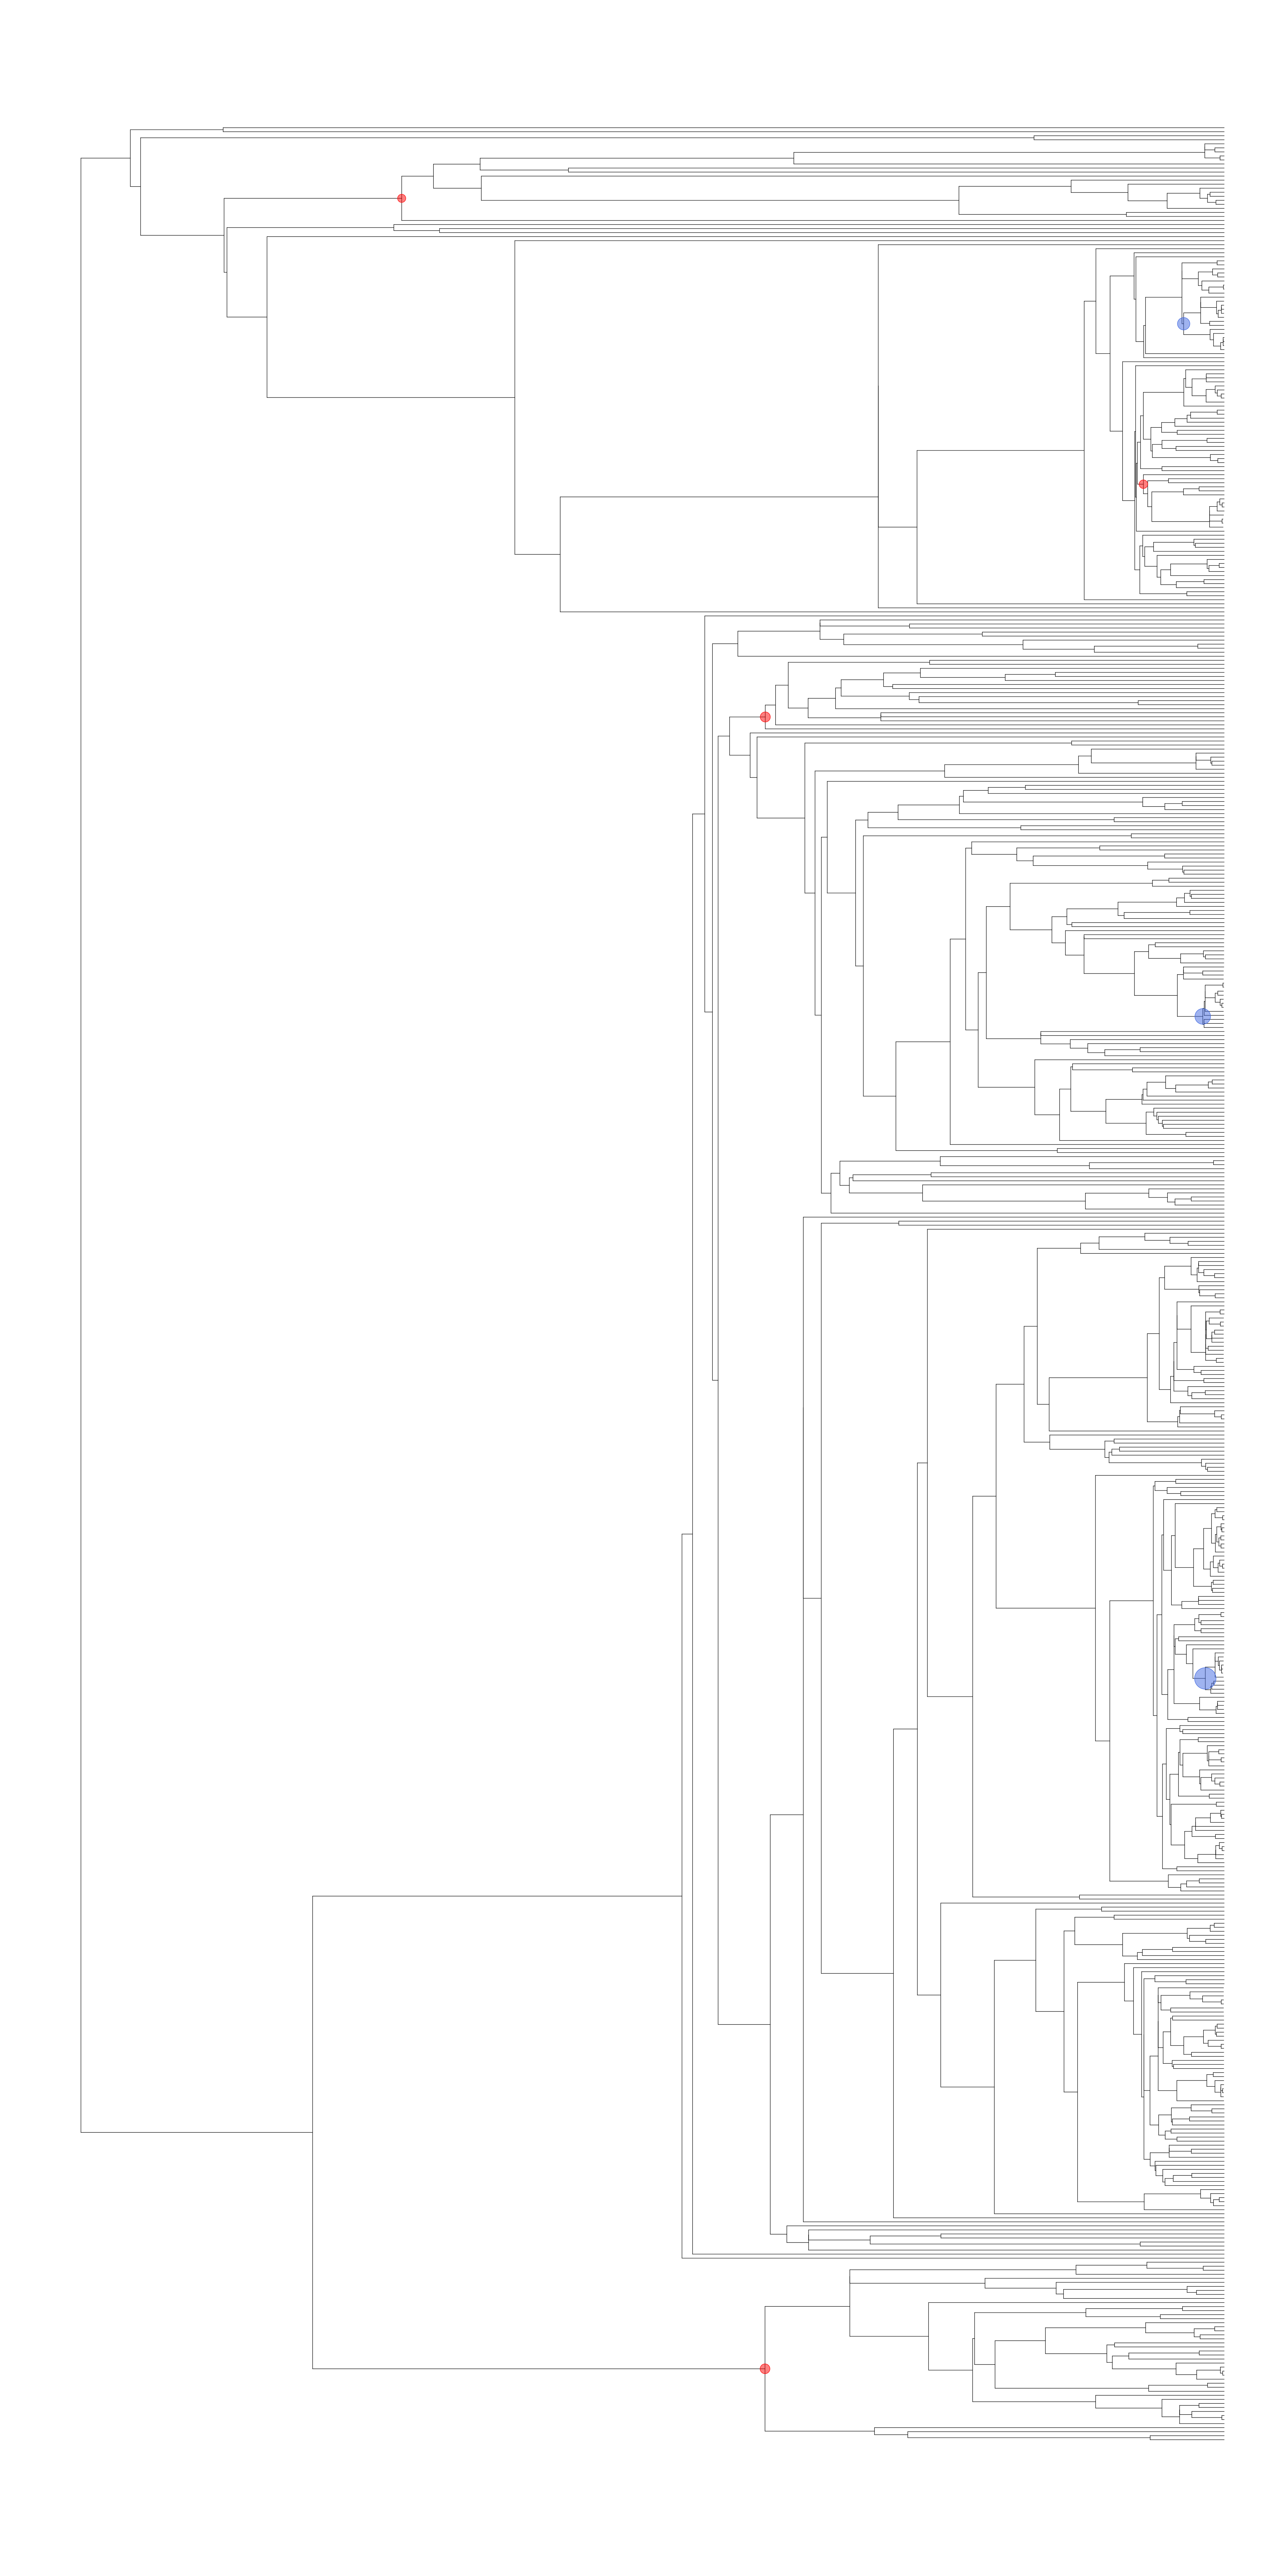

In [87]:
mean_intron_count_res$rate_shifts_plot$plotClades()

---
---
---

## Phylogenetic signal

In [25]:
phylosig(euk_tree_phyla10, phyla10_log_mean_intron_length, method='lambda', test=TRUE)


Phylogenetic signal lambda : 0.995947 
logL(lambda) : 278.602 
LR(lambda=0) : 1342.24 
P-value (based on LR test) : 7.47067e-294 


In [26]:
for (phyl in phyla10){
    phyl_species = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$phylum == phyl,]$species
    phyl_tree = drop.tip(euk_tree_phyla10, euk_tree_phyla10$tip.label[-match(phyl_species, euk_tree_phyla10$tip.label)])
    phyl_data = phyla10_log_mean_intron_length[phyl_species]
    sig = phylosig(phyl_tree, phyl_data, method='lambda', test=TRUE)
    print(paste(phyl, length(phyl_species), sig$lambda, sig$P))
}

[1] "Arthropoda 108 0.988387265664756 1.4797244764981e-15"
[1] "Ascomycota 41 0.843359585848144 6.50460525221606e-06"
[1] "Chordata 251 0.988506331155831 3.88497779248372e-108"
[1] "Cnidaria 10 0.932754304790104 0.17771395121293"
[1] "Mollusca 11 7.33137435857406e-05 1"
[1] "Nematoda 10 0.963453499400973 0.303620186337703"
[1] "Streptophyta 93 0.989453001355115 1.60141465154404e-23"


## RRphylo

In [27]:
rrphylo = RRphylo(euk_tree_phyla10, phyla10_log_mean_intron_length)

In [28]:
rrphylo$aces[rrphylo$aces < 0,]

numeric(0)

### States at phyla MRCAs

In [29]:
# state and rate at phyla MRCAs
for (phyl in phyla10){
    phyl_species = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$phylum == phyl,]$species
    phyl_mrca = findMRCA(euk_tree_phyla10, phyl_species)
    mrca_state = rrphylo$aces[as.character(phyl_mrca),]
    mrca_rate = rrphylo$rates[as.character(phyl_mrca),]
    print(paste(phyl, mrca_state, mrca_rate))
}

[1] "Arthropoda 3.18743092504148 9.88746380364262e-05"
[1] "Ascomycota 2.07852187643547 -0.00106068462051761"
[1] "Chordata 3.32654217158194 0.000983105137775659"
[1] "Cnidaria 3.2009690900839 -0.000224821030213425"
[1] "Mollusca 3.23640626620387 0.000183782772112637"
[1] "Nematoda 3.18608332221022 -0.000219655142831316"
[1] "Streptophyta 2.82930063355663 -0.000122461631473506"


In [30]:
# state and rate at kingdom MRCAs
kingdoms = c('fungi', 'plants', 'animals')
for (kd in kingdoms){
    kd_species = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$kingdom == kd,]$species
    kd_mrca = findMRCA(euk_tree_phyla10, kd_species)
    mrca_state = rrphylo$aces[as.character(kd_mrca),]
    mrca_rate = rrphylo$rates[as.character(kd_mrca),]
    print(paste(kd, mrca_state, mrca_rate))
}

[1] "fungi 2.07852187643547 -0.00106068462051761"
[1] "plants 2.82930063355663 -0.000122461631473506"
[1] "animals 3.20894641469896 0.000596912283473859"


In [31]:
10**3.20894641469896

[1] 1617.88

In [32]:
# root state
root_node = findMRCA(euk_tree_phyla10, euk_tree_phyla10$tip.label)
rrphylo$aces[as.character(root_node),]

525 
2.911357

In [33]:
keep.tip = function(phy, tip){
    all_tips = phy$tip.label
    drop = setdiff(all_tips, tip)
    return(drop.tip(phy,drop))
}

In [34]:
# Sanity check - what happens if we extract the
# tree for each phylum and run RRphylo?
# Do we get similar states at MRCAs?
phyl_rrphlo_res = list()
for (phyl in phyla10){
    print(phyl)
    phyl_species = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$phylum == phyl,]$species
    phyl_tree = keep.tip(euk_tree_phyla10, phyl_species)
    phyl_data = phyla10_log_mean_intron_length[phyl_species]
    phyl_rrphylo = RRphylo(phyl_tree, phyl_data)
    phyl_rrphlo_res[[phyl]] = list('tree'=phyl_tree, 'data'=phyl_data, 'rrphylo'=phyl_rrphylo)
    phyl_root_state = phyl_rrphylo$aces[1]
    print(phyl_root_state)
}

[1] "Arthropoda"
[1] 3.164518
[1] "Ascomycota"
[1] 1.924055
[1] "Chordata"
[1] 3.453774
[1] "Cnidaria"
[1] 2.98676
[1] "Mollusca"
[1] 3.201087
[1] "Nematoda"
[1] 2.695159
[1] "Streptophyta"
[1] 2.742159


### Analyze rates

Need to convert tip labels (species names) to (external) node numbers to create a common language between the phylo object and the RRphylo results

In [35]:
euk_tree_phyla10_tip_numbers = seq(1:length(euk_tree_phyla10_rol$tip.label))
names(euk_tree_phyla10_tip_numbers) = euk_tree_phyla10_rol$tip.label

In [36]:
convert = function(x){
    if (x %in% names(euk_tree_phyla10_tip_numbers)){
        return(euk_tree_phyla10_tip_numbers[x])
    }
    else{
        return(x)
    }
    
}

In [37]:
rrphylo_rates = as.data.frame(rrphylo$rates)
colnames(rrphylo_rates) = c('Rate')
rownames(rrphylo_rates) = sapply(rownames(rrphylo_rates), convert)

In [38]:
# rates on branches within each phylum
rates_df = data.frame()
mrca = c()
for (phyl in phyla10){
    phyl_species = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$phylum == phyl,]$species
    phyl_mrca = findMRCA(euk_tree_phyla10, phyl_species)
    mrca = c(mrca, as.character(phyl_mrca))
    # nodes under MRCA
    phyl_nodes = as.character(getDescendants(euk_tree_phyla10, phyl_mrca))  
    phyl_rates = rrphylo_rates[phyl_nodes,1,drop=FALSE]
    phyl_rates$type = 'under'
    # nodes above MRCA
    path_to_root = getMommy(euk_tree_phyla10, phyl_mrca)
    path_to_root = as.character(c(head(path_to_root, -1), phyl_mrca))
    path_to_root_rates = rrphylo_rates[path_to_root,1,drop=FALSE]
    path_to_root_rates$type = 'above'
    # combine
    phyl_rates = rbind(phyl_rates, path_to_root_rates)
    phyl_rates$node = rownames(phyl_rates)
    colnames(phyl_rates) = c('Rate', 'type', 'node')
    phyl_rates$phylum = phyl
    rates_df = rbind(rates_df, phyl_rates)
}

In [39]:
# DF of branch lengths
br_df = as.data.frame(cbind(euk_tree_phyla10$edge[,2], euk_tree_phyla10$edge.length))
colnames(br_df) = c('node','branch_length')
#rownames(br_df) = br_df$node

In [40]:
# merge branch length and rates data
rates_br_df = merge(br_df, rates_df, by = 'node', all = TRUE)

In [41]:
# write to file (analyze and plot with python)
write.table(rates_br_df, file='br_len_rates.tsv', sep = '\t', row.names = FALSE)

In [42]:
# rates on branches leading to each phylum
anc_rates_df = data.frame()
for (phyl in phyla10){
    phyl_species = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$phylum == phyl,]$species
    phyl_mrca = findMRCA(euk_tree_phyla10, phyl_species)
    path_to_root = getMommy(euk_tree_phyla10, phyl_mrca)
    path_to_root = c(head(path_to_root, -1), phyl_mrca)
    phyl_nodes = as.character(path_to_root)
    phyl_rates = rrphylo_rates[phyl_nodes,1,drop=FALSE]
    colnames(phyl_rates) = c('Rate')
    phyl_rates$phylum = phyl
    anc_rates_df = rbind(anc_rates_df, phyl_rates)
}

In [43]:
anc_rates_df

Rate          phylum      
821   3.354216e-05 Arthropoda  
820  -2.196551e-04 Arthropoda  
819  -1.363191e-05 Arthropoda  
568   5.833050e-05 Arthropoda  
567   5.969123e-04 Arthropoda  
526  -1.115693e-04 Arthropoda  
822   9.887464e-05 Arthropoda  
5261 -1.115693e-04 Ascomycota  
527  -1.060685e-03 Ascomycota  
5681  5.833050e-05 Chordata    
5671  5.969123e-04 Chordata    
5262 -1.115693e-04 Chordata    
569   9.831051e-04 Chordata    
5672  5.969123e-04 Cnidaria    
5263 -1.115693e-04 Cnidaria    
947  -2.248210e-04 Cnidaria    
8191 -1.363191e-05 Mollusca    
5682  5.833050e-05 Mollusca    
5673  5.969123e-04 Mollusca    
5264 -1.115693e-04 Mollusca    
937   1.837828e-04 Mollusca    
8192 -1.363191e-05 Nematoda    
5683  5.833050e-05 Nematoda    
5674  5.969123e-04 Nematoda    
5265 -1.115693e-04 Nematoda    
8201 -2.196551e-04 Nematoda    
956  -1.224616e-04 Streptophyta

In [44]:
# merge branch length and rates data
anc_rates_br_df = merge(br_df, anc_rates_df, by = 'row.names', all = TRUE)
# remove rows with missing data
anc_rates_br_df = anc_rates_br_df[complete.cases(anc_rates_br_df), ]
# remove unneeded column
anc_rates_br_df = anc_rates_br_df[,c(2,3,4,5)]
anc_rates_br_df
# write to file (analyze and plot with python)
#write.table(rates_br_df, file='br_len_rates.tsv', sep = '\t', row.names = FALSE)

node branch_length Rate          phylum      
522   258  25.05000     -1.115693e-04 Arthropoda  
528   794   0.27174     -1.060685e-03 Ascomycota  
572   280  35.49080      5.969123e-04 Arthropoda  
577   281  35.49080      5.833050e-05 Arthropoda  
581   282  46.33630      9.831051e-04 Chordata    
859   936 372.99600     -1.363191e-05 Arthropoda  
863   409 213.34600     -2.196551e-04 Arthropoda  
865   410 213.34600      3.354216e-05 Arthropoda  
866   937 148.10700      9.887464e-05 Arthropoda  
993   996   4.29878      1.837828e-04 Mollusca    
1004  470   9.00000     -2.248210e-04 Cnidaria    
1014 1006  14.98020     -1.224616e-04 Streptophyta

### Rate shifts

In [45]:
search_shifts = search.shift(rrphylo, status.type="clade", f=10)

In [46]:
#search_shifts$all.clades[search_shifts$all.clades$p.value < 0.05,]
search_shifts$single.clades

rate.difference p.value
769  -0.001116917    0.001  
848  -0.001218227    0.001  
937  -0.001299667    0.001  
918  -0.001070959    0.008  
879   0.004795242    1.000  
1026  0.004492251    1.000

In [47]:
# list species under each shift node
euk_tree_phyla10_numbers_tips = setNames(names(euk_tree_phyla10_tip_numbers), euk_tree_phyla10_tip_numbers)
for (shift_node in rownames(search_shifts$single.clades)){
    print(shift_node)
    shift_tips = tips(euk_tree_phyla10, as.numeric(shift_node))
    print(paste(shift_tips, collapse=' '))
}

[1] "769"
[1] "crocodylus_porosus struthio_camelus nothoprocta_perdicaria apteryx_owenii apteryx_haastii apteryx_rowi dromaius_novaehollandiae calidris_pugnax otus_sunia bubo_bubo strix_occidentalis athene_cunicularia accipiter_nisus aquila_chrysaetos melopsittacus_undulatus amazona_collaria strigops_habroptila parus_major cyanistes_caeruleus zosterops_lateralis catharus_ustulatus ficedula_albicollis corvus_moneduloides camarhynchus_parvulus taeniopygia_guttata lonchura_striata junco_hyemalis zonotrichia_albicollis serinus_canaria manacus_vitellinus lepidothrix_coronata malurus_cyaneus falco_tinnunculus anas_platyrhynchos anas_zonorhyncha anser_brachyrhynchus cairina_moschata coturnix_japonica phasianus_colchicus chrysolophus_pictus meleagris_gallopavo pavo_cristatus gallus_gallus numida_meleagris pelusios_castaneus pelodiscus_sinensis gopherus_agassizii chelonoidis_abingdonii chrysemys_picta chelydra_serpentina"
[1] "848"
[1] "monomorium_pharaonis solenopsis_invicta atta_cephalotes po

In [48]:
euk_tree_phyla10_edges = euk_tree_phyla10$edge
node_to_edge = 1:nrow(euk_tree_phyla10_edges)
names(node_to_edge) = euk_tree_phyla10_edges[,2]

In [49]:
pos_shift_nodes = rownames(search_shifts$single.clades[search_shifts$single.clades$rate.difference > 0,])
pos_shift_nodes = as.numeric(pos_shift_nodes)
#pos_shift_edges = unname(node_to_edge[pos_shift_nodes])
neg_shift_nodes = rownames(search_shifts$single.clades[search_shifts$single.clades$rate.difference < 0,])
neg_shift_nodes = as.numeric(neg_shift_nodes)
#neg_shift_edges = unname(node_to_edge[neg_shift_nodes])

### Plot colored phylogenies

In [50]:
rrphylo_plot = plotRR(rrphylo, phyla10_log_mean_intron_length)

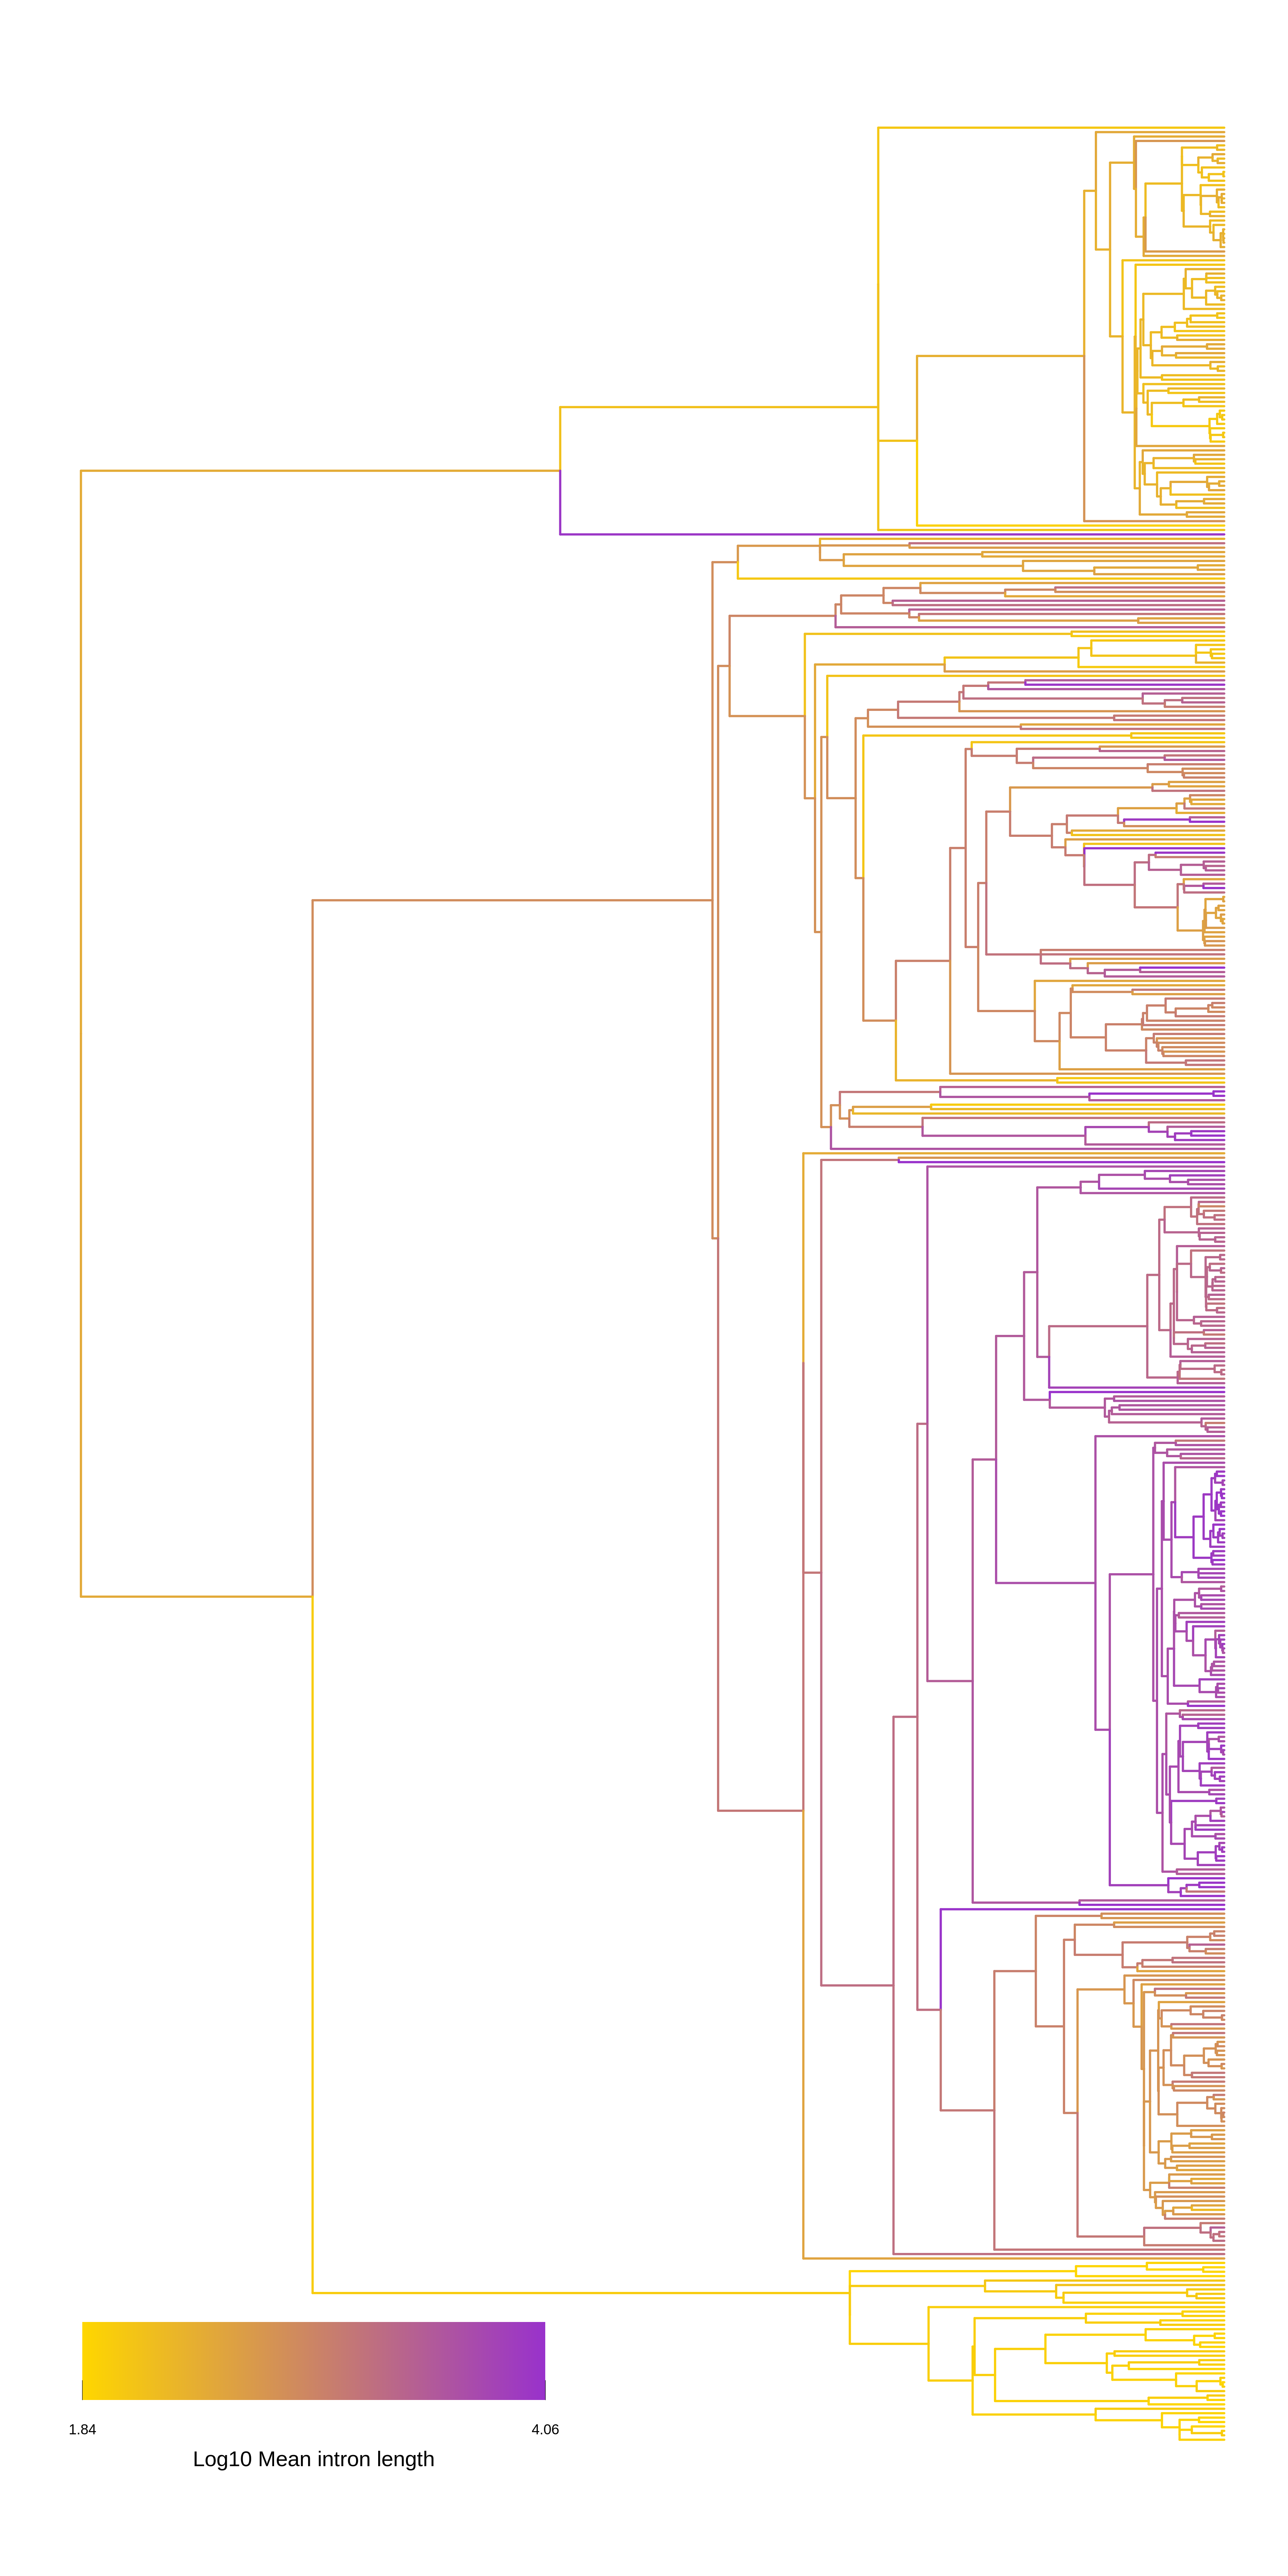

In [51]:
options(repr.plot.width=30, repr.plot.height=60)
color_pal = colorRampPalette(c("gold", "darkorchid"))
tree_args = list(edge.width=5)
colorbar_args = list(direction='horizontal',x=2,y=10, height=0.5,width=1.5,border=NA,title.pos='bottom',labs.cex=2,title='Log10 Mean intron length',title.cex=3,title.adj=c(0.5,-4))
rrphylo_plot$plotRRphen(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)

In [52]:
fig_name = 'fig_4a'
fig_path = file.path(figures_dir, paste0(fig_name,'.pdf'))
pdf(fig_path, width=30, height=60)
rrphylo_plot$plotRRphen(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)
dev.off()

png 
  2

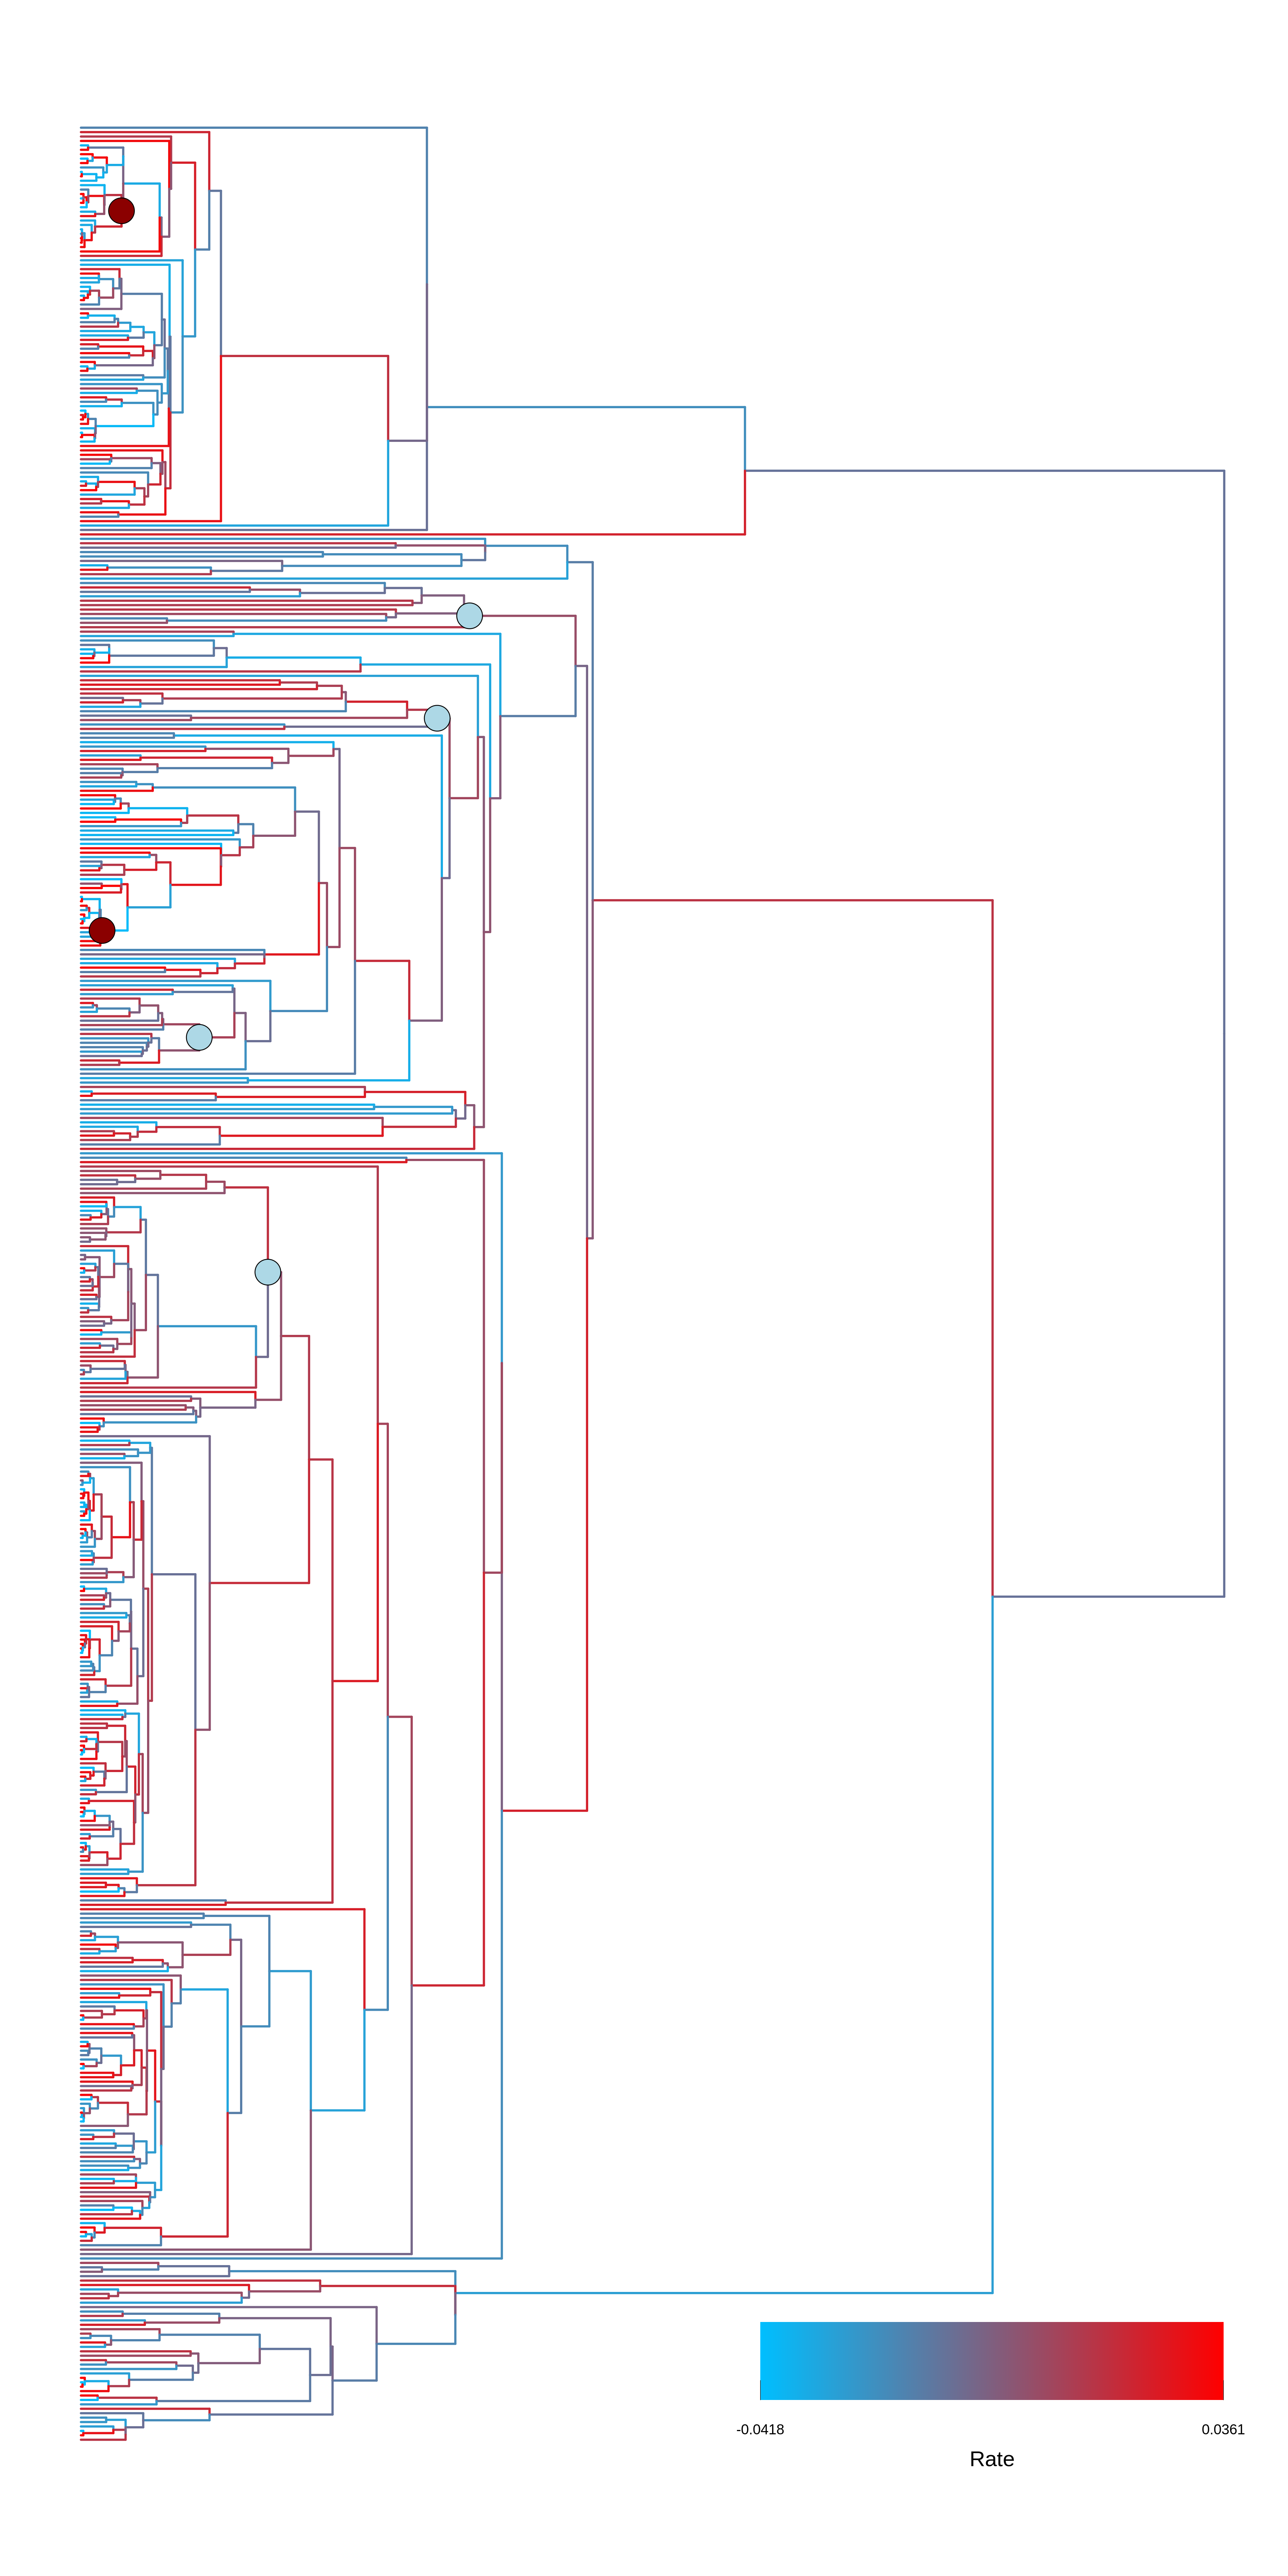

In [53]:
options(repr.plot.width=30, repr.plot.height=60)
color_pal = colorRampPalette(c("deepskyblue", "red"))
tree_args = list(edge.width=5, direction='leftwards')
colorbar_args = list(direction='horizontal',x=950,y=10, height=0.5,width=1.5,border=NA,title.pos='bottom',labs.cex=2,title='Rate',title.cex=3,title.adj=c(0.5,-4))
rrphylo_plot$plotRRrates(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)
nodelabels(node=pos_shift_nodes, pch=21, cex=8, col='black', bg='darkred', lwd=2)
nodelabels(node=neg_shift_nodes, pch=21, cex=8, col='black', bg='lightblue', lwd=2)

In [54]:
fig_name = 'fig_4b'
fig_path = file.path(figures_dir, paste0(fig_name,'.pdf'))
pdf(fig_path, width=30, height=60)
rrphylo_plot$plotRRrates(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)
nodelabels(node=pos_shift_nodes, pch=21, cex=8, col='black', bg='darkred', lwd=2)
nodelabels(node=neg_shift_nodes, pch=21, cex=8, col='black', bg='lightblue', lwd=2)
dev.off()

png 
  2

## Phylogenetic ANOVA

In [55]:
# species: phylum mapping
phyla10_species_phylum = phyla10_intron_length_stats_df$phylum
names(phyla10_species_phylum) = phyla10_intron_length_stats_df$species

In [56]:
# rescale tree by RRPhylo rates
euk_tree_phyla10_rescale = rescaleRR(euk_tree_phyla10,RR=rrphylo)

In [57]:
# phylum-level phylogenetic ANOVA
set.seed(100)
phyl_anova = phylANOVA(euk_tree_phyla10_rescale, phyla10_species_phylum, phyla10_log_mean_intron_length)
phyl_anova

ANOVA table: Phylogenetic ANOVA

Response: y
            Sum Sq   Mean Sq    F value Pr(>F)
x        103.20260 17.200433 261.210299   0.07
Residual  34.04393  0.065849                  

P-value based on simulation.
---------

Pairwise posthoc test using method = "holm"

Pairwise t-values:
             Arthropoda Ascomycota   Chordata   Cnidaria   Mollusca  Nematoda
Arthropoda     0.000000   25.77069  -7.947225   3.564301  -0.361140  8.345085
Ascomycota   -25.770685    0.00000 -33.493593 -10.063129 -14.258619 -5.582540
Chordata       7.947225   33.49359   0.000000   6.489752   2.597864 11.390302
Cnidaria      -3.564301   10.06313  -6.489752   0.000000  -2.958030  3.533567
Mollusca       0.361140   14.25862  -2.597864   2.958030   0.000000  6.574751
Nematoda      -8.345085    5.58254 -11.390302  -3.533567  -6.574751  0.000000
Streptophyta -15.180620   13.76164 -25.224006  -2.912743  -7.093753  1.835699
             Streptophyta
Arthropoda      15.180620
Ascomycota     -13.761636
Chordat

In [58]:
# species:kingdom mapping
phyla10_species_kingdom = phyla10_intron_length_stats_df$kingdom
names(phyla10_species_kingdom) = phyla10_intron_length_stats_df$species

In [59]:
# kingdom-level phylogenetic ANOVA
set.seed(100)
phylANOVA(euk_tree_phyla10_rescale, phyla10_species_kingdom, phyla10_log_mean_intron_length)

ANOVA table: Phylogenetic ANOVA

Response: y
           Sum Sq   Mean Sq    F value Pr(>F)
x        89.63266 44.816330 490.388864  0.076
Residual 47.61386  0.091389                  

P-value based on simulation.
---------

Pairwise posthoc test using method = "holm"

Pairwise t-values:
          animals    fungi    plants
animals   0.00000 26.97951  19.40737
fungi   -26.97951  0.00000 -11.68145
plants  -19.40737 11.68145   0.00000

Pairwise corrected P-values:
        animals fungi plants
animals   1.000 0.108  0.424
fungi     0.108 1.000  0.424
plants    0.424 0.424  1.000
---------


## PGLS - Intron size vs. genome size

In [60]:
# complete missing genome sizes
l = list()
l$arabidopsis_thaliana = 119667750
l$danaus_plexippus = 248676414
l$fraxinus_excelsior = 867455155
l$onthophagus_taurus = 267079363
l$parasteatoda_tepidariorum = 1228972128
l$quercus_suber = 953298670
l$aegilops_tauschii = 4224915394
l$arabis_alpina = 308032609
l$trichinella_spiralis = 63525422

for (x in names(l)){
    phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$species == x,'Genome_size'] = l[[x]]
}

In [61]:
phyla10_intron_length_stats_df$log_Genome_size = log10(phyla10_intron_length_stats_df$Genome_size)

In [84]:
euk_tree_phyla10$node.label = NULL
pgls_data = comparative.data(phy=euk_tree_phyla10, data=phyla10_intron_length_stats_df[,c('species','log_Mean','log_Genome_size')], names.col=species, vcv=TRUE, vcv.dim=3)
pglsModel_caper = pgls(log_Mean ~ log_Genome_size, data = pgls_data, lambda='ML', delta='ML')
all_pgls_sum = summary(pglsModel_caper)
all_pgls_sum


Call:
pgls(formula = log_Mean ~ log_Genome_size, data = pgls_data, 
    lambda = "ML", delta = "ML")

Residuals:
      Min        1Q    Median        3Q       Max 
-0.096663 -0.014855  0.000778  0.012866  0.101154 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 0.993
   lower bound : 0.000, p = < 2.22e-16
   upper bound : 1.000, p = < 2.22e-16
   95.0% CI   : (0.988, 0.996)
delta  [ ML]  : 0.854
   lower bound : 0.000, p = 2.4203e-07
   upper bound : 3.000, p = 0.0012667
   95.0% CI   : (0.088, 2.109)

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.633089   0.363964  1.7394  0.08255 .  
log_Genome_size 0.255856   0.026875  9.5201  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02317 on 522 degrees of freedom
Multiple R-squared: 0.1479,	Adjusted R-squared: 0.1463 
F-statistic: 90.63 on 1 and 522 DF,  p-value: < 2.2e-16 

In [89]:
all_pgls_sum$coefficients[1,4]

[1] 0.0825491

In [90]:
all_pgls_int = all_pgls_sum$coefficients[1,1]
all_pgls_int_p = all_pgls_sum$coefficients[1,4]
if (all_pgls_int_p > 0.05){
    all_pgls_int = 0
}
all_pgls_coef = all_pgls_sum$coefficients[2,1]
all_pgls_r2 = all_pgls_sum$adj.r.squared

In [91]:
res_df = data.frame(all_pgls_int, all_pgls_coef, all_pgls_r2)
for (phyl in names(phyl_rrphlo_res)){
    phyl_species = names(phyl_rrphlo_res[[phyl]]$data)
    phyl_data = phyla10_intron_length_stats_df[phyla10_intron_length_stats_df$species %in% phyl_species,]
    phyl_tree = phyl_rrphlo_res[[phyl]]$tree
    phyl_tree_rescale = rescaleRR(phyl_tree,RR=phyl_rrphlo_res[[phyl]]$rrphylo)
    phyl_tree$node.label = NULL
    phyl_pgls_data = comparative.data(phy=phyl_tree, data=phyl_data[,c('species','log_Mean','log_Genome_size')], names.col=species, vcv=TRUE, vcv.dim=3)
    phyl_pgls = pgls(log_Mean ~ log_Genome_size, data = phyl_pgls_data, lambda='ML', delta='ML')
    sum = summary(phyl_pgls)
    intercept = sum$coefficients[1,1]
    intercept_p = sum$coefficients[1,4]
    if (intercept_p > 0.05){
        intercept = 0
    }
    coef = sum$coefficients[2,1]
    r2 = sum$adj.r.squared
    phyl_pgls_res = c(intercept, coef, r2)
    res_df = rbind(res_df, phyl_pgls_res)
}
rownames(res_df) = c('All', names(phyl_rrphlo_res))
colnames(res_df) = c('Intercept', 'Coefficient',' R^2')
res_df

Intercept Coefficient   R^2       
All           0.000000 0.2558555467  0.14630584
Arthropoda   -4.198567 0.8431050036  0.65533556
Ascomycota    2.046339 0.0005623955 -0.02564036
Chordata     -2.667482 0.6699162027  0.39923596
Cnidaria     -7.384535 1.2076353993  0.87370531
Mollusca     -4.065238 0.8181763916  0.81584037
Nematoda      0.000000 0.7376613568  0.46874167
Streptophyta  2.270321 0.0884586667  0.05160690

In [95]:
write.table(res_df, 'PGLS.tsv', sep = '\t', quote = FALSE)

### EMmeans to determine if phyla are significantly different

In [66]:
pglsModel = gls(log_Mean ~ log_Genome_size + phylum, correlation = corBrownian(phy = euk_tree_phyla10_rescale, form=~species),
    data = phyla10_intron_length_stats_df, method = "ML")
summary(pglsModel)

Generalized least squares fit by maximum likelihood
  Model: log_Mean ~ log_Genome_size + phylum 
  Data: phyla10_intron_length_stats_df 
        AIC       BIC   logLik
  -1034.014 -995.6603 526.0069

Correlation Structure: corBrownian
 Formula: ~species 
 Parameter estimate(s):
numeric(0)

Coefficients:
                        Value Std.Error   t-value p-value
(Intercept)         1.2621098 0.2301581  5.483664  0.0000
log_Genome_size     0.1957422 0.0228079  8.582213  0.0000
phylumAscomycota   -0.4548414 0.2719837 -1.672311  0.0951
phylumChordata      0.1734438 0.1353626  1.281327  0.2007
phylumCnidaria     -0.1997988 0.1294030 -1.544005  0.1232
phylumMollusca      0.0669002 0.1129493  0.592303  0.5539
phylumNematoda     -0.3488313 0.1552980 -2.246207  0.0251
phylumStreptophyta -0.0357383 0.1932177 -0.184964  0.8533

 Correlation: 
                   (Intr) lg_Gn_ phylmA phylmCh phylmCn phylmM phylmN
log_Genome_size    -0.853                                            
phylumAscomycota

In [67]:
pgls_emmeans = emmeans(pglsModel, list(pairwise ~ phylum))

In [68]:
summary(pgls_emmeans)

$`emmeans of phylum`
 phylum       emmean    SE  df lower.CL upper.CL
 Arthropoda     2.99 0.120 515     2.76     3.23
 Ascomycota     2.54 0.248 515     2.05     3.02
 Chordata       3.17 0.135 515     2.90     3.43
 Cnidaria       2.79 0.159 515     2.48     3.10
 Mollusca       3.06 0.153 515     2.76     3.36
 Nematoda       2.64 0.174 515     2.30     2.99
 Streptophyta   2.96 0.151 515     2.66     3.25

Degrees-of-freedom method: df.error 
Confidence level used: 0.95 

$`pairwise differences of phylum`
 1                         estimate    SE  df t.ratio p.value
 Arthropoda - Ascomycota     0.4548 0.272 515   1.672  0.6349
 Arthropoda - Chordata      -0.1734 0.135 515  -1.281  0.8604
 Arthropoda - Cnidaria       0.1998 0.129 515   1.544  0.7180
 Arthropoda - Mollusca      -0.0669 0.113 515  -0.592  0.9970
 Arthropoda - Nematoda       0.3488 0.155 515   2.246  0.2728
 Arthropoda - Streptophyta   0.0357 0.193 515   0.185  1.0000
 Ascomycota - Chordata      -0.6283 0.281 515  -2.232  0.2802
 Ascomycota - Cnidaria      -0.2550 0.290 515  -0.879  0.9756
 Ascomycota - Mollusca      -0.5217 0.288 515  -1.808  0.5429
 Ascomycota - Nematoda      -0.1060 0.298 515  -0.355  0.9998
 Ascomycota - Streptophyta  -0.4191 0.290 515  -1.443  0.7780
 Chordata - Cnidaria         0.3732 0.162 515   2.299  0.2463
 Chordata - Mollusca         0.1065 0.151 515   0.707  0.9922
 Chordata - Nematoda         0.5223 0.191 515   2.741  0.0903
 Chordata - Streptophyta     0.2092 0.203 515   1.032  0.9464
 Cnidaria - Mollusca        -0.2667 0.137 515  -1.947  0.4499
 Cnidaria - Nematoda         0.1490 0.188 515   0.791  0.9858
 Cnidaria - Streptophyta    -0.1641 0.219 515  -0.748  0.9894
 Mollusca - Nematoda         0.4157 0.179 515   2.324  0.2344
 Mollusca - Streptophyta     0.1026 0.215 515   0.477  0.9991
 Nematoda - Streptophyta    -0.3131 0.231 515  -1.356  0.8250

Degrees-of-freedom method: df.error 
P value adjustment: tukey method for comparing a family of 7 estimates

### RRphylo with genome size as a predictor for intron size

In [108]:
phyla10_log_genome_size = phyla10_intron_length_stats_df$log_Genome_size
names(phyla10_log_genome_size) = phyla10_intron_length_stats_df$species
rrphylo_genome_size = RRphylo(euk_tree_phyla10, phyla10_log_genome_size)

In [109]:
rrphylo_plot = plotRR(rrphylo_genome_size, phyla10_log_genome_size)

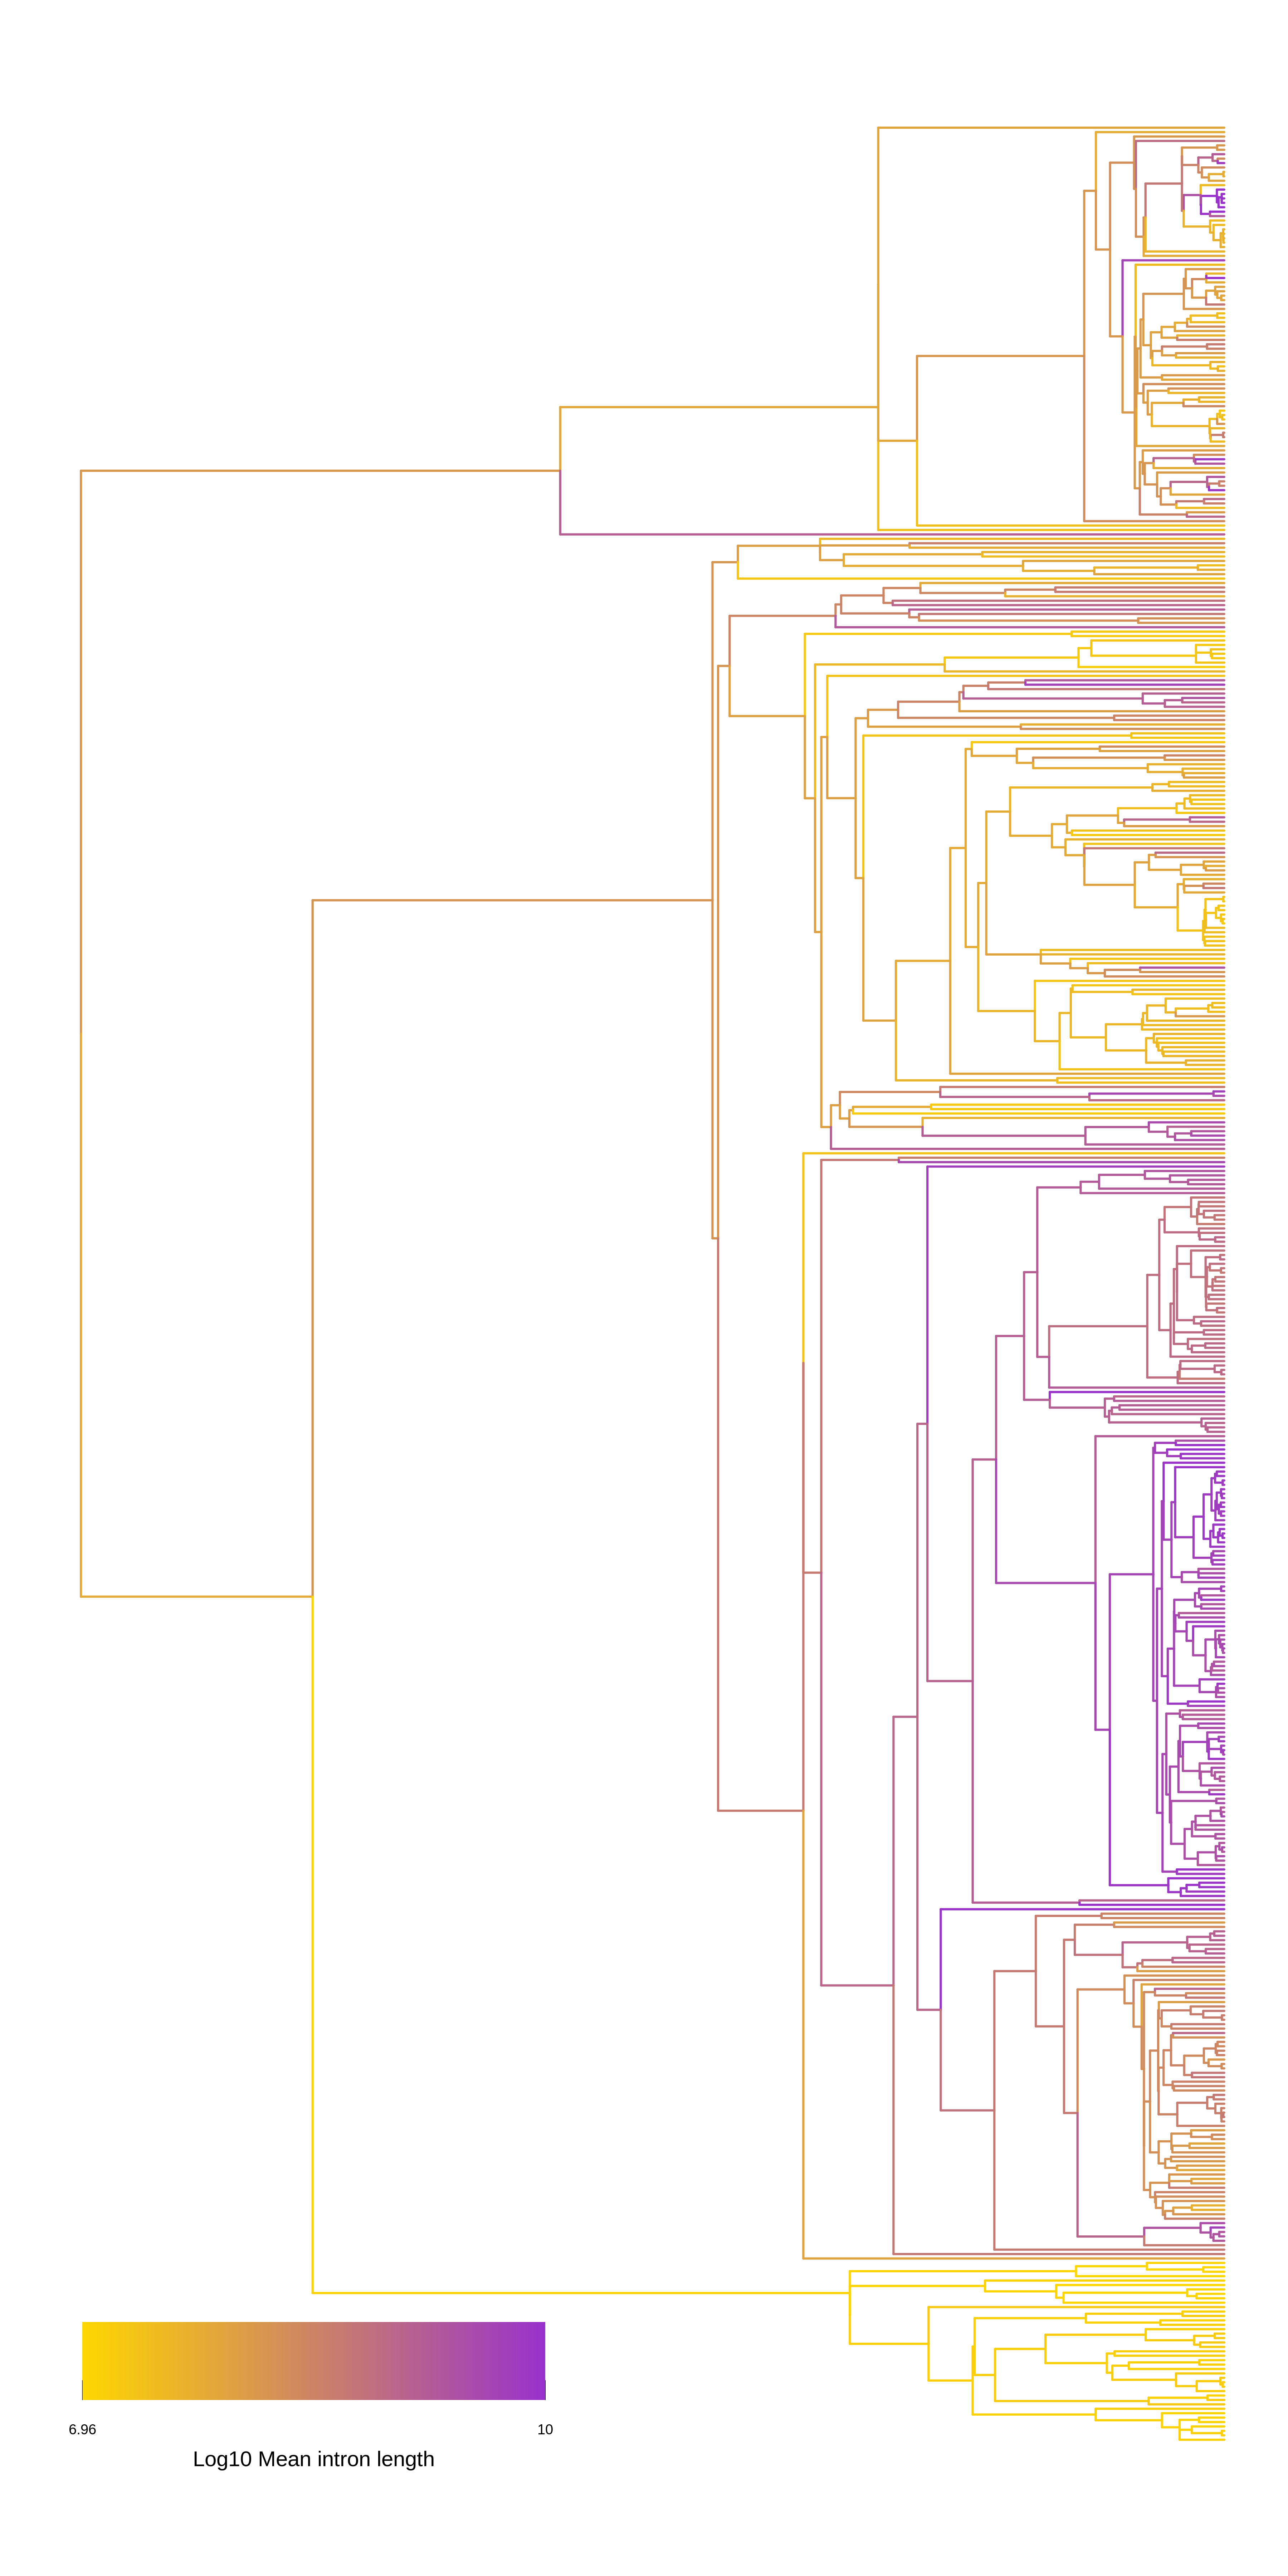

In [110]:
options(repr.plot.width=30, repr.plot.height=60)
color_pal = colorRampPalette(c("gold", "darkorchid"))
tree_args = list(edge.width=5)
colorbar_args = list(direction='horizontal',x=2,y=10, height=0.5,width=1.5,border=NA,title.pos='bottom',labs.cex=2,title='Log10 Mean intron length',title.cex=3,title.adj=c(0.5,-4))
rrphylo_plot$plotRRphen(colorbar.args = colorbar_args, color.pal=color_pal, tree.args=tree_args)

In [111]:
phyla10_log_genome_size_aces = rrphylo_genome_size$aces[,1]
phyla10_log_genome_size_pred = c(phyla10_log_genome_size_aces, phyla10_log_genome_size)

In [112]:
rrphylo_multi = RRphylo(euk_tree_phyla10, phyla10_log_mean_intron_length, x1=phyla10_log_genome_size_pred)